# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 12 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels_, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds, perc_in_level
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'results/descriptives/'#attd/'

for d in ('availability', 'hist', 'cdf', 'boxplot', 'time_in_zone', 'time_cycling', 'events', 'timeseries'):
    if not os.path.exists(SAVE_PATH+d):
        os.makedirs(SAVE_PATH+d)

In [3]:
COL = 'Glucose Value (mg/dL)'

In [4]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

## Data

### Read data

**Athlete characteristics**

In [5]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Blood tests**

In [6]:
hba1c = pd.read_csv(DATA_PATH+'bloodtests/HbA1c.csv', header=[0,1,2], index_col=[0])
hba1c = hba1c.mean(level=0, axis=1) # calc mean over seasons
hba1c = hba1c.reset_index()
hba1c

RIDER      2018      2019
0       1       NaN  6.333333
1       2  7.200000  6.533333
2       3  7.100000  6.850000
3       4       NaN  8.000000
4       5  6.800000  6.725000
5       6       NaN  6.550000
6       7  6.825000  6.366667
7       9  7.075000  7.025000
8      10  6.833333  7.233333
9      12  6.025000  5.950000
10     13       NaN  6.366667
11     14  7.650000  6.925000
12     15  6.775000  6.525000
13     16       NaN  6.825000

**Professional**

In [7]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [8]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [9]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [10]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_min vertical_speed_max   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
30207                NaN                   NaN                  NaN   
30208                NaN                   NaN                  NaN   
30209                NaN                   NaN                  NaN   
30210                NaN                   NaN                  NaN   
30211                NaN                   NaN                  NaN   

                                                                              \
      vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                    NaN             NaN                NaN              NaN   
1                    NaN             NaN                NaN              NaN   
2                    NaN             NaN               

**Dexcom (aggregated)**

In [11]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')

dc_agg['date'] = pd.to_datetime(dc_agg['date'])

dc_agg = dc_agg.dropna(subset=['glucose_mean_'+i for i in ('exercise', 'recovery', 'sleep', 'wake')], how='all')
dc_agg = dc_agg.reset_index(drop=True)
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RIDER       date  time_in_hypo_day  time_in_hypoL2_day  \
0          1 2017-09-12                 0                   0   
1          1 2017-09-13                 0                   0   
2          1 2017-09-14                 7                   0   
3          1 2017-09-15                17                   0   
4          1 2017-09-16                10                   1   
...      ...        ...               ...                 ...   
11803      9 2020-02-11                 0                   0   
11804      9 2020-02-12                 1                   0   
11805      9 2020-02-13                 1                   0   
11806      9 2020-07-23                 0                   0   
11807      9 2020-07-24                 0                   0   

       time_in_hypoL1_day  time_in_target_day  time_in_hyper_day  \
0                       0                 130                 30   
1                       0                 203                 85   
2                       7                 247                 46   
3                      17                 254                 17   
4                       9                 189                 22   
...                   ...                 ...                ...   
11803                   0                 149                111   
11804                   1                 199                 33   
11805                   1                 117                  8   
11806                   0                   0                  1   
11807                   0                   7                  5   

       time_in_hyperL1_day  time_in_hyperL2_day  perc_in_hypo_day  ...  \
0                       30                    0          0.000000  ...   
1                       68                   17          0.000000  ...   
2                       46                    0          2.333333  ...   
3                       17                    0          5.902778  ...   
4                       22                    0          4.524887  ...   
...                    ...                  ...               ...  ...   
11803                  106                    5          0.000000  ...   
11804                   25                    8          0.429185  ...   
11805                    8                    0          0.793651  ...   
11806                    1                    0          0.000000  ...   
11807                    5                    0          0.000000  ...   

       count_sleep  LBGI_sleep  HBGI_sleep  AUC_sleep  hypo_sleep  \
0             72.0    0.000000    2.233929    10130.5       False   
1             72.0    1.006374    0.007478     6910.0       False   
2             72.0    1.302753    0.001658     6824.5       False   
3             72.0    0.000000    1.007591     9408.5       False   
4             72.0    1.190592    0.000083     6808.0       False   
...            ...         ...         ...        ...         ...   
11803         72.0    0.462046    6.585822    11036.7       False   
11804         72.0    0.009297    1.769761     9824.4       False   
11805          0.0    0.000000    0.000000        NaN       False   
11806          0.0    0.000000    0.000000        NaN       False   
11807          0.0    0.000000    0.000000        NaN       False   

       hyper_sleep  race_day  travel_day  exercise_day  completeness  
0            False     False       False          True      0.555556  
1            False     False       False          True      1.000000  
2            False     False       False          True      1.000000  
3            False     False        True          True      1.000000  
4            False     False       False          True      0.767361  
...            ...       ...         ...           ...           ...  
11803         True     False       False         False      0.902778  
11804        False     False       False          True      0.809028  
11805        False     False       False          Tr

**Dexcom (full)**

In [12]:
# TODO: check if we still need this cell!!
dc = pd.read_csv(DATA_PATH+'agg/dexcom.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc['date'])
dc

RIDER           timestamp  Glucose Value (mg/dL)  \
0             1 2014-01-01 00:00:00                    NaN   
1             1 2014-01-01 00:05:00                    NaN   
2             1 2014-01-01 00:10:00                    NaN   
3             1 2014-01-01 00:15:00                    NaN   
4             1 2014-01-01 00:20:00                    NaN   
...         ...                 ...                    ...   
15147643     18 2021-12-31 23:35:00                    NaN   
15147644     18 2021-12-31 23:40:00                    NaN   
15147645     18 2021-12-31 23:45:00                    NaN   
15147646     18 2021-12-31 23:50:00                    NaN   
15147647     18 2021-12-31 23:55:00                    NaN   

             local_timestamp  exercise  recovery   wake  sleep       date  \
0        2013-12-31 20:00:00     False     False   True  False 2013-12-31   
1        2013-12-31 20:05:00     False     False   True  False 2013-12-31   
2        2013-12-31 20:10:00     False     False   True  False 2013-12-31   
3        2013-12-31 20:15:00     False     False   True  False 2013-12-31   
4        2013-12-31 20:20:00     False     False   True  False 2013-12-31   
...                      ...       ...       ...    ...    ...        ...   
15147643 2022-01-01 00:35:00     False     False  False   True 2021-12-31   
15147644 2022-01-01 00:40:00     False     False  False   True 2021-12-31   
15147645 2022-01-01 00:45:00     False     False  False   True 2021-12-31   
15147646 2022-01-01 00:50:00     False     False  False   True 2021-12-31   
15147647 2022-01-01 00:55:00     False     False  False   True 2021-12-31   

          race_day  travel_day  exercise_day   hypo  hyper  glucose_rate  \
0            False       False         False  False  False           NaN   
1            False       False         False  False  False           NaN   
2            False       False         False  False  False           NaN   
3            False       False         False  False  False           NaN   
4            False       False         False  False  False           NaN   
...            ...         ...           ...    ...    ...           ...   
15147643     False       False         False  False  False           NaN   
15147644     False       False         False  False  False           NaN   
15147645     False       False         False  False  False           NaN   
15147646     False       False         False  False  False           NaN   
15147647     False       False         False  False  False           NaN   

          completeness  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
15147643           0.0  
15147644           0.0  
15147645           0.0  
15147646           0.0  
15147647           0.0  

[15146832 rows x 16 columns]

### Plot data availability

In [13]:
dc_avail = dc_agg.pivot(index='RIDER', columns='date', values='completeness_day')

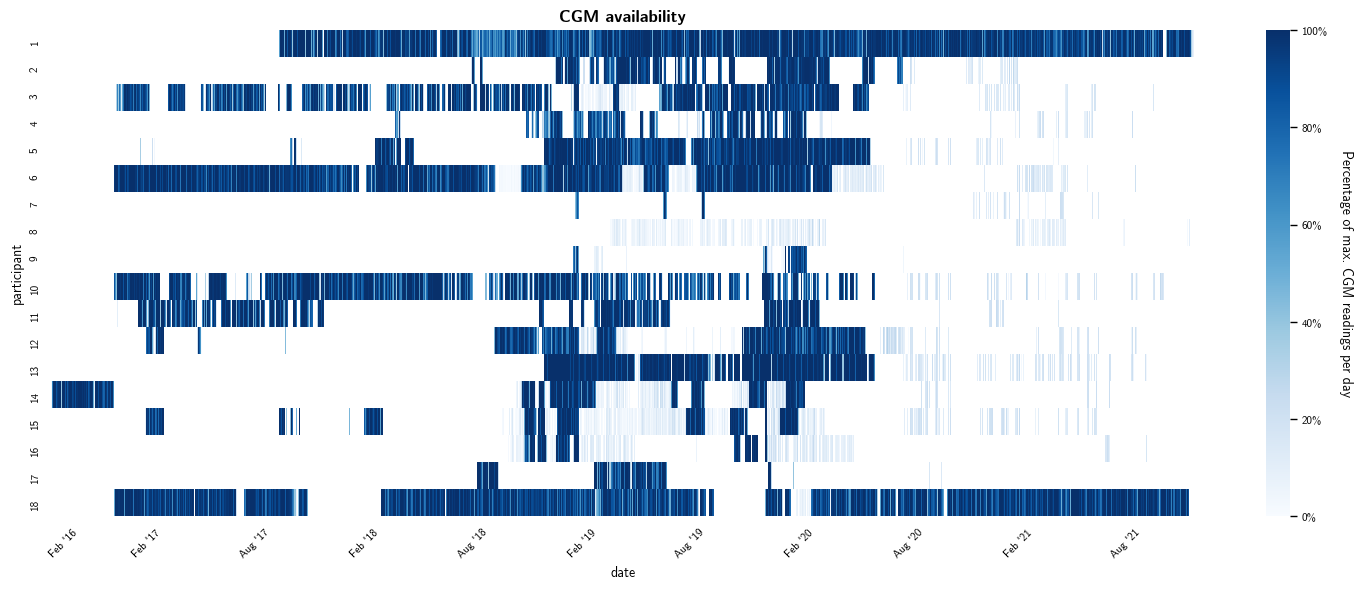

In [14]:
ax = plot_availability(dc_avail, rot_months=45, itv_months=6)
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', yticks=ax)

In [15]:
pro_list = pro.set_index('RIDER').stack().replace({'-':'np.nan'}).reset_index().rename(columns={'level_1':'year', 0:'pro'})
pro_list['year'] = pro_list['year'].astype(int)
pro_list.columns = pd.MultiIndex.from_product([pro_list.columns, ['']])
pro_list

RIDER  year     pro
                       
0       1  2014  np.nan
1       1  2015  np.nan
2       1  2016  np.nan
3       1  2017     DEV
4       1  2018     DEV
..    ...   ...     ...
139    18  2017     DEV
140    18  2018     DEV
141    18  2019     DEV
142    18  2020     DEV
143    18  2021     PRO

[144 rows x 3 columns]

In [16]:
tp_agg['year'] = tp_agg['date'].dt.year
tp_agg = pd.merge(tp_agg, pro_list, on=['RIDER', 'year'], how='left')
tp_agg = tp_agg.drop([('year')], axis=1)
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_max vertical_speed_sum   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_energy vertical_speed_peaks vertical_speed_rms   
0                       NaN                  NaN                NaN   
1                       NaN                  NaN                NaN   
2                       NaN                  NaN                NaN   
3                       NaN                  NaN                NaN   
4                       NaN                  NaN                NaN   
...                     ...                  ...                ...   
30207                   NaN                  NaN                NaN   
30208                   NaN                  NaN                NaN   
30209                   NaN                  NaN                NaN   
30210                   NaN                  NaN                NaN   
30211                   NaN                  NaN                NaN   

                                                                              \
      distance_up_iqr vertical_speed_iqr acceleration_iqr elevation_gain_iqr   
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              N

In [17]:
tp_avail = tp_agg.pivot(index='RIDER', columns='date', values='pro')
tp_avail = tp_avail.replace({'PRO':2, 'DEV':1, 'np.nan':np.nan})

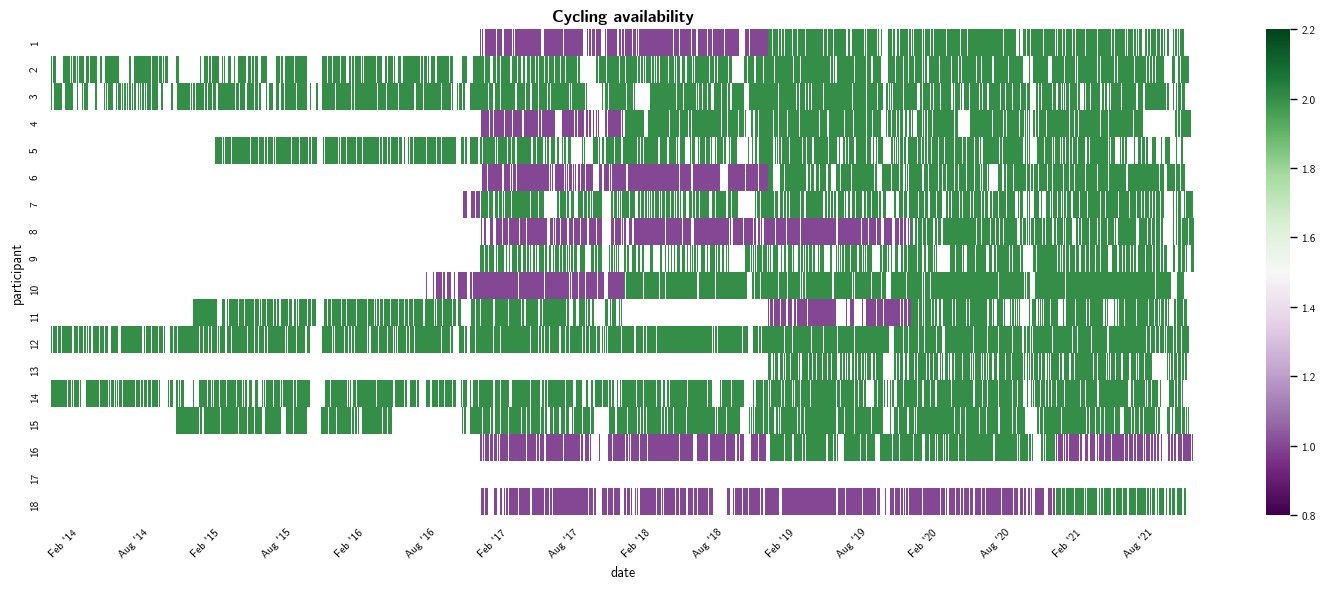

In [18]:
ax = plot_availability(tp_avail, cmap='PRGn', vmin=0.8, vmax=2.2, 
                       rot_months=45, itv_months=6, plot_colorbar=False)
plt.title('Cycling availability', fontweight='bold', fontsize=12)
savefig('availability/cycling_availability_all', yticks=ax)

In [18]:
tp_agg = tp_agg.drop('pro', axis=1)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [19]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))#.dropna(subset=['glucose_mean_day'])))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11808
Dexcom: N = 18 ; D = 11808


### Select data

#### Select riders that were pro in 2019

In [20]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [21]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')
hba1c = hba1c[hba1c.RIDER.isin(ATHLETES)].set_index('RIDER')

In [22]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom (agg): N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc[dc.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc[dc.RIDER.isin(ATHLETES)].dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 25116
Dexcom (agg): N = 14 ; D = 9246
Dexcom: N = 14 ; D = 9246


#### Select beginning and end of the training season in 2019

In [23]:
hba1c = hba1c['2019']
hba1c.name = 'HbA1c'

In [24]:
# merge 
info = info.drop('HbA1c', axis=1)
info = pd.merge(info, hba1c, left_index=True, right_index=True, how='left')

In [25]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

RIDER       date
0         1 2018-11-05
1         1 2018-11-06
2         1 2018-11-07
3         1 2018-11-08
4         1 2018-11-09
...     ...        ...
4642     16 2019-09-25
4643     16 2019-09-26
4644     16 2019-09-27
4645     16 2019-09-28
4646     16 2019-09-29

[4647 rows x 2 columns]

In [26]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc = pd.merge(dc, season_list, how='inner', on=['RIDER', 'date'])

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [27]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 3071
Dexcom: N = 14 ; D = 3071


#### Select days with glucose completeness >= 70%

In [28]:
print("Percentage of days with completeness larger than 70%: {:.1f}%"\
      .format(100*(dc_agg['completeness_day'] >= 0.7).sum()/len(dc_agg)))

Percentage of days with completeness larger than 70%: 69.5%


In [29]:
print("Percentage of values that remain after the completeness constraints: {:.1f}%"\
      .format(len(dc[dc.completeness >= 0.7].dropna(subset=['Glucose Value (mg/dL)']))\
              /len(dc.dropna(subset=['Glucose Value (mg/dL)']))*100))

Percentage of values that remain after the completeness constraints: 91.5%


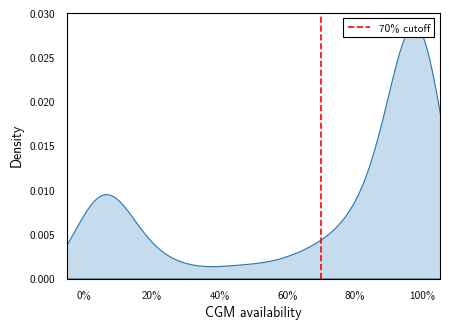

In [35]:
from matplotlib.ticker import PercentFormatter
plt.figure()
ax = sns.kdeplot(dc_agg['completeness_day']*100, fill=True)
plt.axvline(70, ls='--', color='red', label='70% cutoff')
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.savefig(SAVE_PATH+'availability/completeness_cutoff_pdf.png', dpi=1000)#, bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/completeness_cutoff_pdf.pdf')#, bbox_inches='tight')
plt.show()
plt.close()

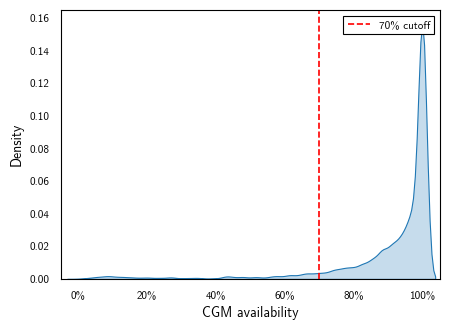

In [36]:
from matplotlib.ticker import PercentFormatter
plt.figure()
ax = sns.kdeplot(dc.dropna(subset=['Glucose Value (mg/dL)'])['completeness']*100, fill=True)
plt.axvline(70, ls='--', color='red', label='70% cutoff')
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.savefig(SAVE_PATH+'availability/completeness_cutoff_values_pdf.png', dpi=1000)#, bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/completeness_cutoff_values_pdf.pdf')#, bbox_inches='tight')
plt.show()
plt.close()

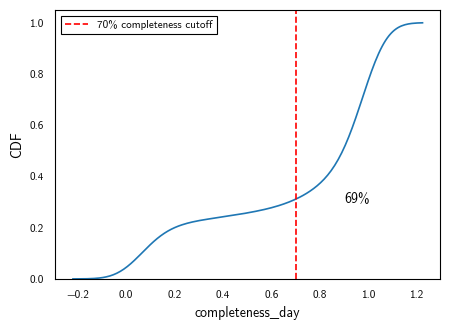

In [37]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness_day', cumulative=True)
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,0.3, '{:.0f}%'.format((dc_agg['completeness_day'] >= 0.7).sum()/dc_agg['completeness_day'].count()*100))
plt.legend()
plt.ylabel('CDF')
plt.savefig(SAVE_PATH+'availability/completeness_cutoff_cdf.png', dpi=1000)#, bbox_inches='tight')
plt.show()

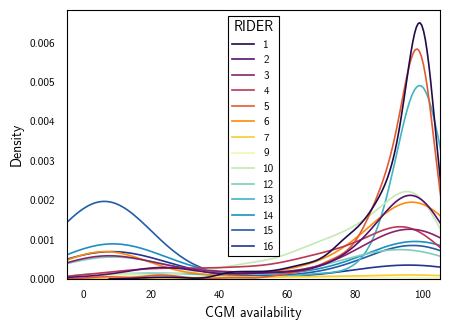

In [38]:
plt.figure()
sns.kdeplot(data=dc_agg, x=dc_agg['completeness_day']*100, hue='RIDER', palette= sns.color_palette('inferno', n_colors=7)+ sns.color_palette('YlGnBu', n_colors=7))
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.show()

Calendar with glucose availability

In [30]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_day')

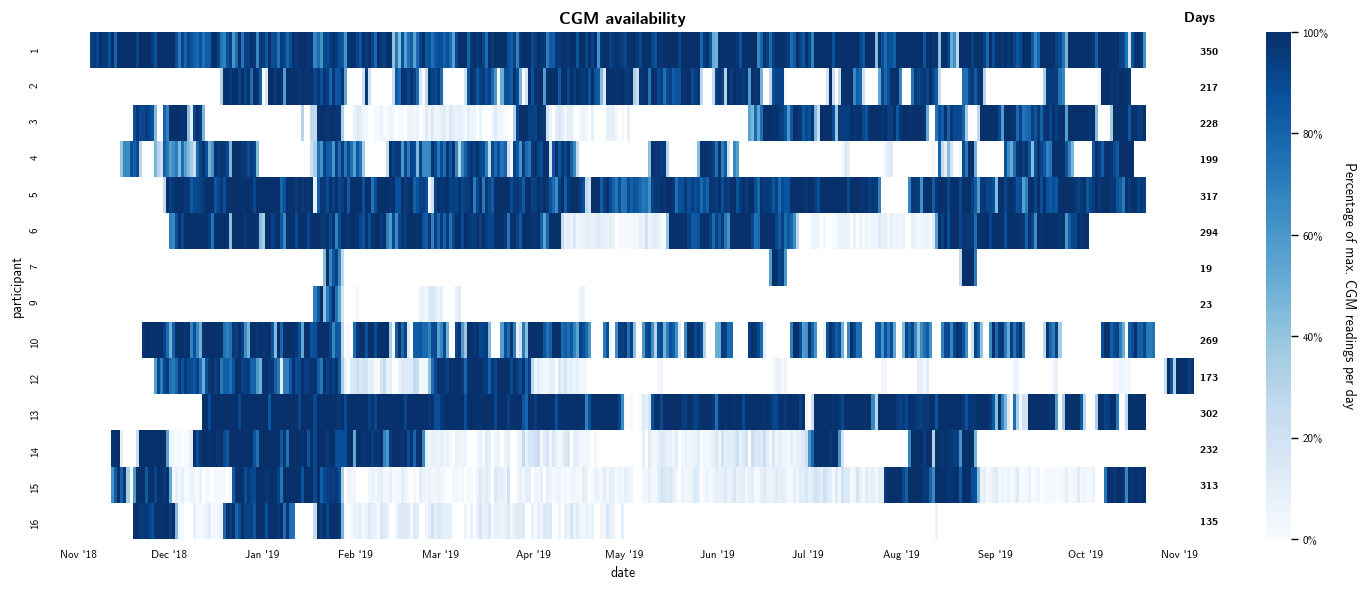

In [40]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability', yticks=ax)

Select data with glucose completeness >= 70% (on a day from 6am to 6am) and remove nans from dexcom data

In [31]:
dc.loc[dc['completeness'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [32]:
dc_agg = dc_agg[dc_agg['completeness_day'] >= 0.7]

In [33]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 2133
Dexcom: N = 14 ; D = 2133


#### Select participants with 14 or more days of data

In [34]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index

info = info.loc[ATHLETES]
season_list = season_list[season_list.RIDER.isin(ATHLETES)]

tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]
dc = dc[dc.RIDER.isin(ATHLETES)]

In [35]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 12 ; D = 3370
Dexcom (agg): N = 12 ; D = 2115
Dexcom: N = 12 ; D = 2115


In [36]:
print("Race days: ", 
      len(dc.loc[dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Race days with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day'] & dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Training days: ", 
      len(dc.loc[dc['exercise_day'] & ~dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Exercise days: ", 
      len(dc.loc[dc['exercise_day'], ['RIDER', 'date']].drop_duplicates()))

Race days:  261
Race days with CGM during exercise:  256
Training days:  1536
Exercise days:  1792


In [37]:
season_length = season_list.groupby('RIDER').count()
print("Season length: {:.1f} [{:.1f}-{:.1f}]".format(season_length.median().item(), 
                                                     season_length.quantile(0.25).item(),
                                                     season_length.quantile(0.75).item()))

Season length: 340.0 [314.5-343.5]


**Give participants a new ID (so that it is not confusing for the paper)**

In [38]:
map_id = {i: n+1 for n, i in enumerate(dc.groupby('RIDER').apply(stat_func).apply(pd.Series)['perc_in_target_'].sort_values(ascending=False).index)}
map_id

{13: 1,
 6: 2,
 5: 3,
 12: 4,
 15: 5,
 3: 6,
 2: 7,
 1: 8,
 16: 9,
 14: 10,
 4: 11,
 10: 12}

In [39]:
ATHLETES = sorted([*map(map_id.get, ATHLETES)])

info.index = info.index.map(map_id)
info = info.sort_index()

season.index = season.index.map(map_id)
season = season.sort_index()

season_list.RIDER = season_list.RIDER.map(map_id)

tp_agg.RIDER = tp_agg.RIDER.map(map_id)
dc_agg.RIDER = dc_agg.RIDER.map(map_id)
dc.RIDER = dc.RIDER.map(map_id)

rider_mapping_inv = {map_id[k]:v for k,v in rider_mapping_inv.items() if k in map_id.keys()}

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_day')

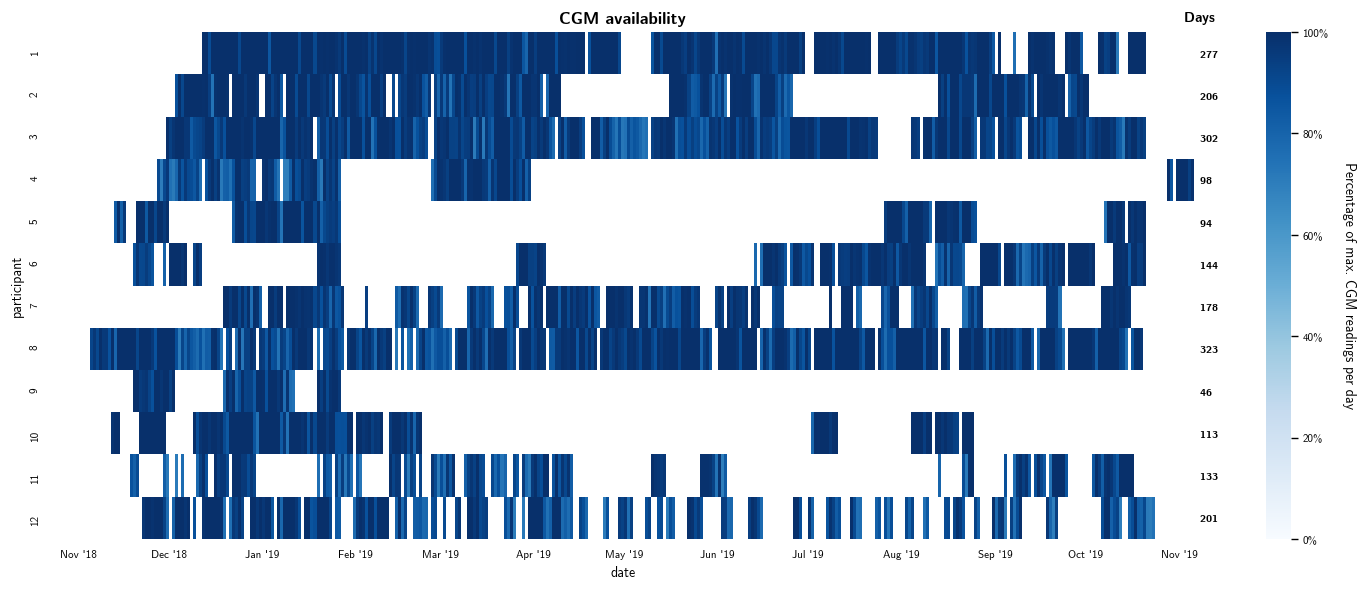

In [51]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_selectcomp', yticks=ax)

## Descriptives Dexcom

In [41]:
def get_percinlevel(dc, col='Glucose Value (mg/dL)'):
    return {l: perc_in_level(dc[col], l, extend=False) for l, _ in glucose_levels_.items()}

### Glucose distribution (histograms)

All data

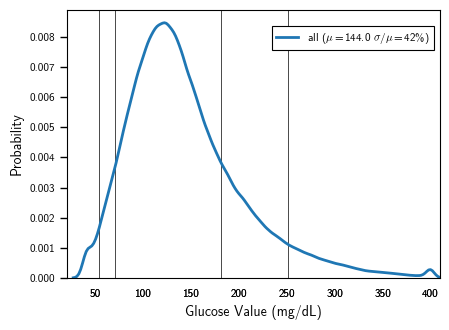

In [53]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='hist/hist_glucose')

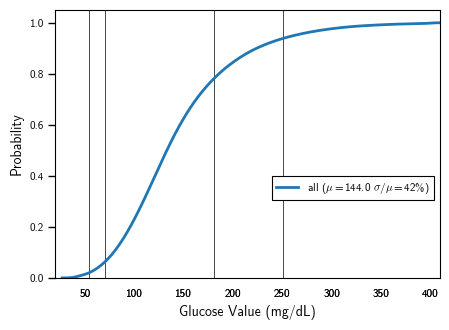

In [54]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, cumulative=True, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
ax.set_xlabel(COL)
savefig(path='cdf/cdf_glucose')

All, hue: sections

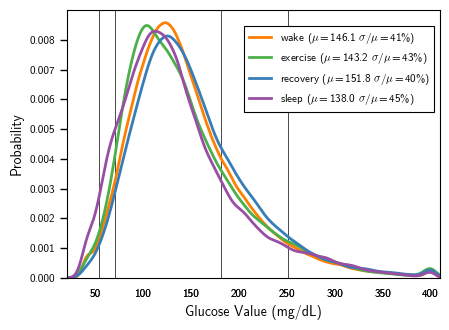

In [55]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_sec')

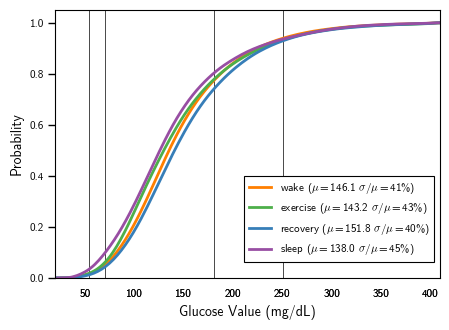

In [56]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, cumulative=True, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
savefig(path='cdf/cdf_glucose_sec')

Individual athletes, hue: sections

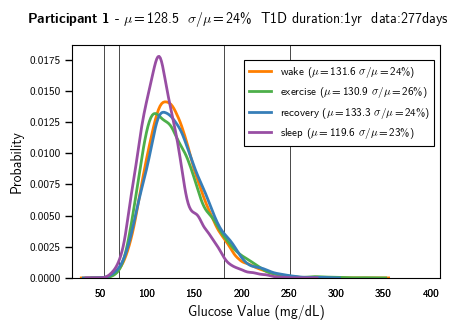

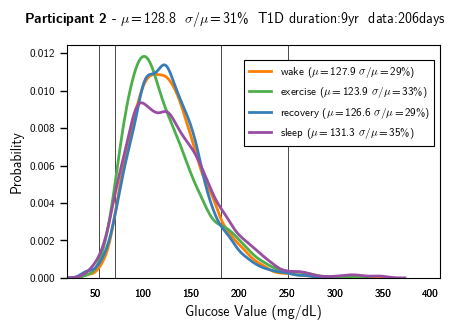

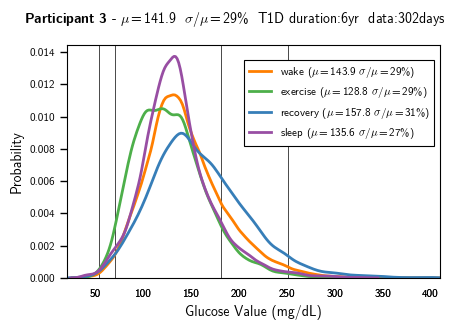

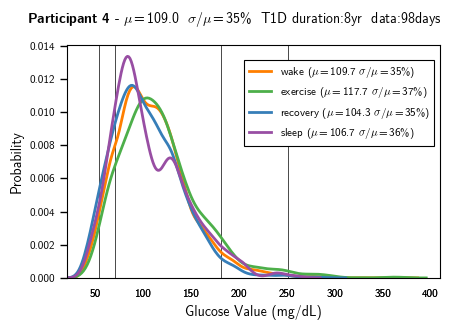

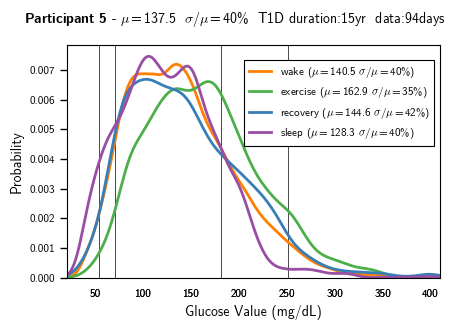

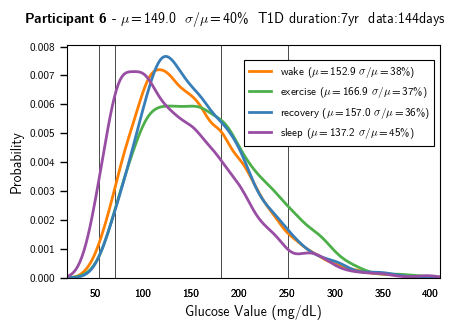

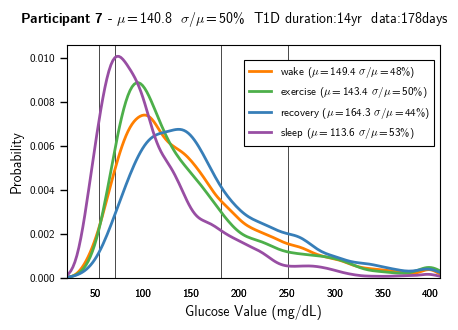

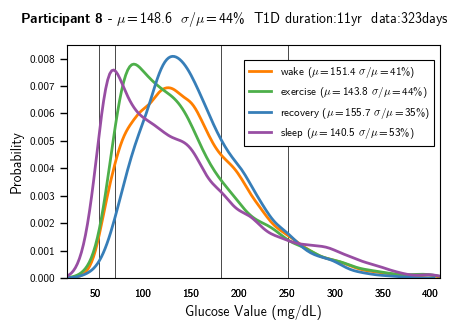

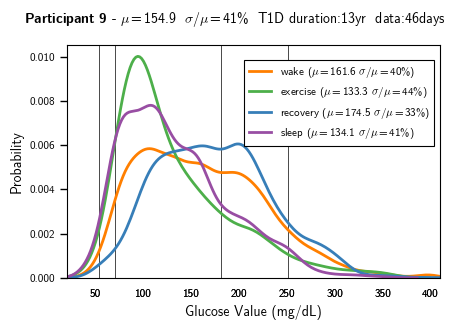

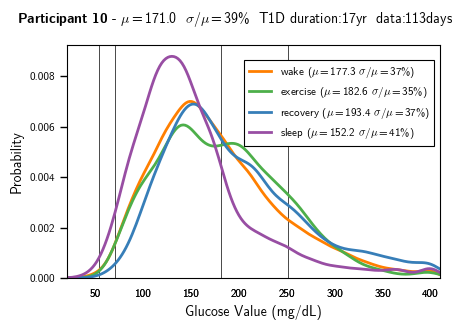

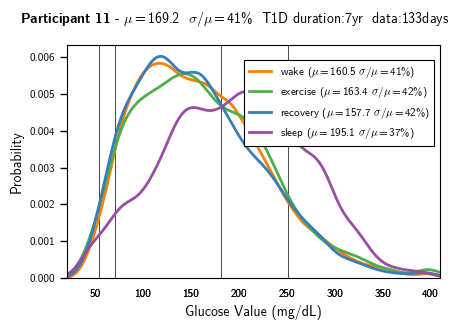

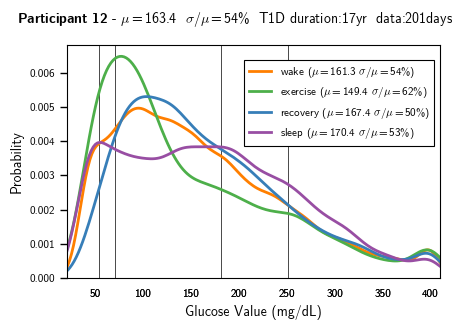

In [57]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='hist/hist_glucose_rider', i=i, title=title, x=0.45, y=1.06)

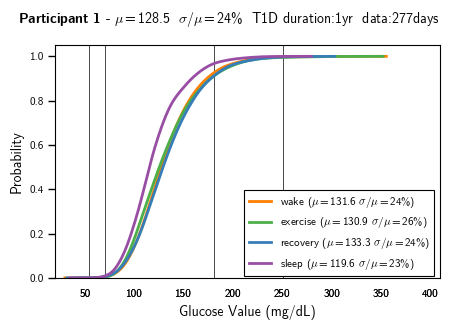

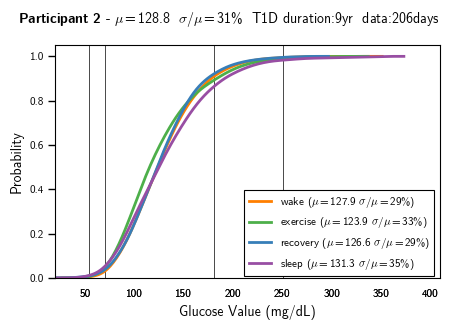

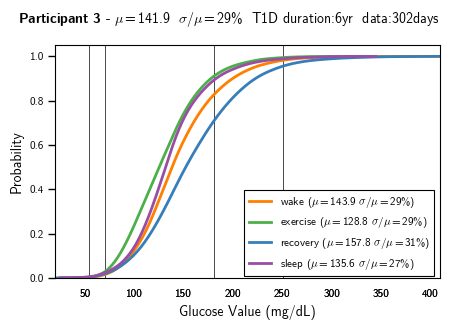

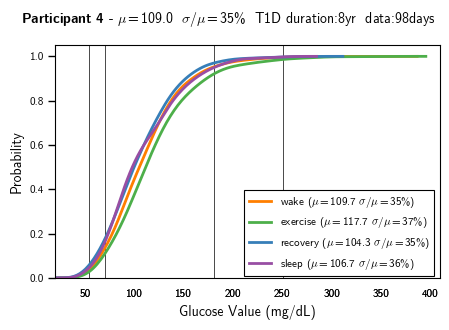

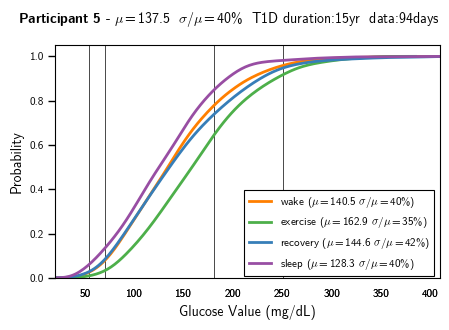

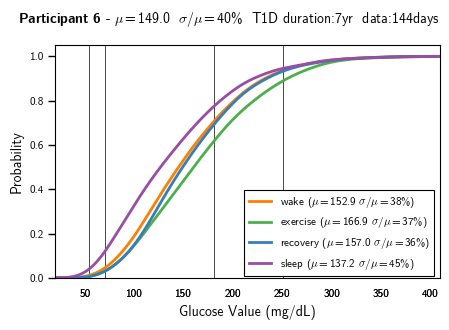

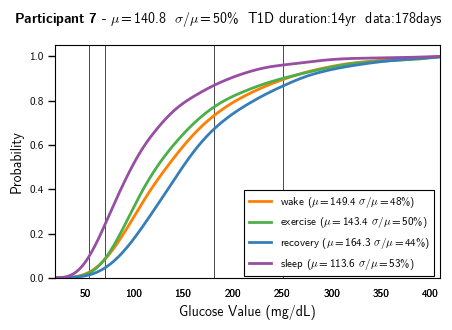

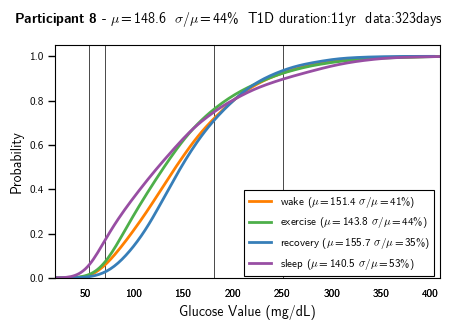

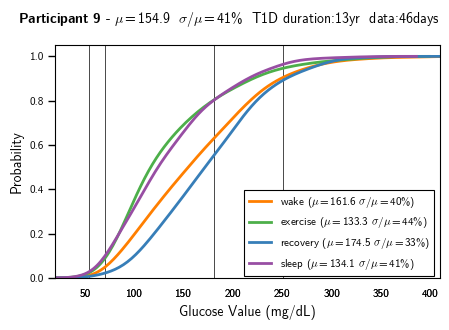

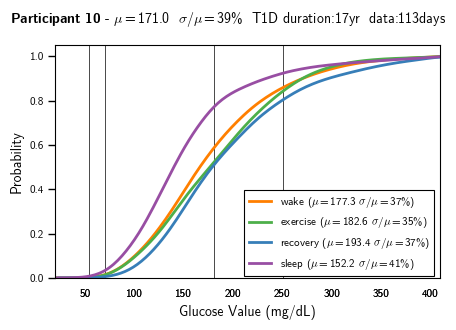

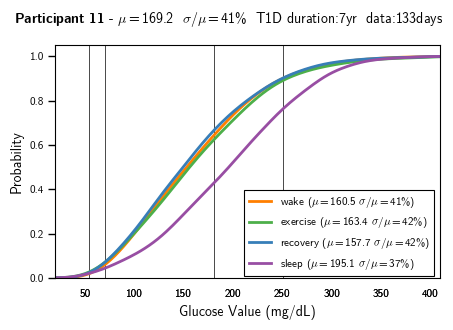

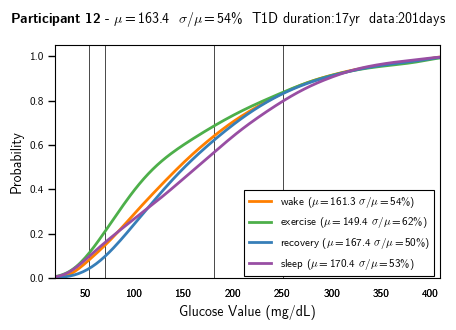

In [58]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, cumulative=True, 
			linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='cdf/cdf_glucose_rider', i=i, title=title, x=0.45, y=1.06)

All, hue: athletes

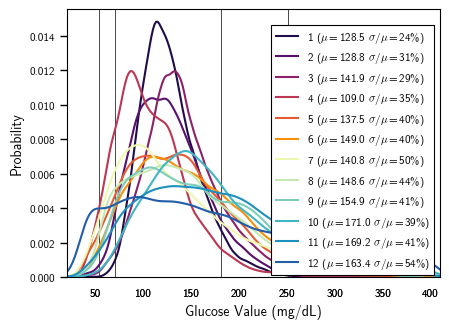

In [59]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_riders', legend=ax.get_legend().get_texts())

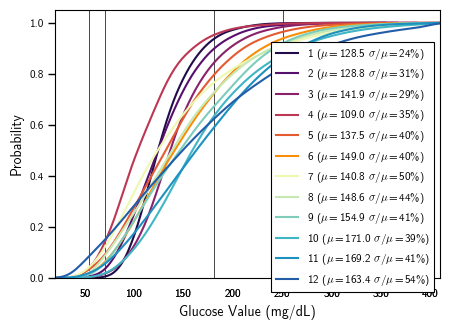

In [60]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, cumulative=True,
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
savefig(path='cdf/cdf_glucose_riders', legend=ax.get_legend().get_texts())

Sections individually, hue: athletes

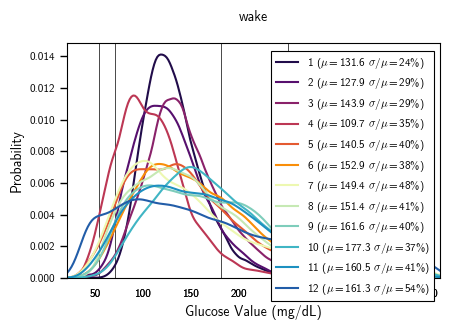

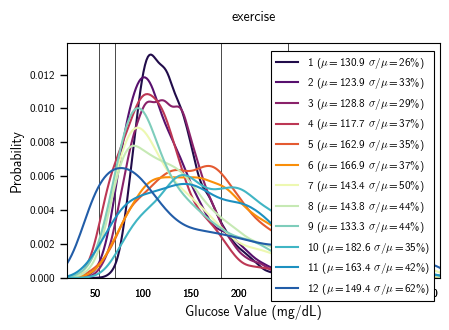

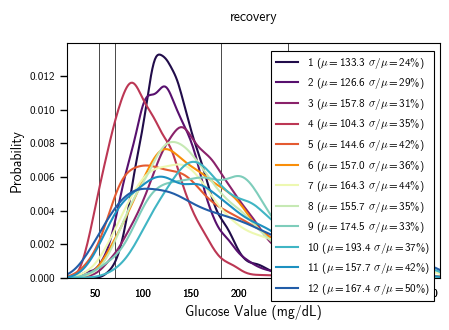

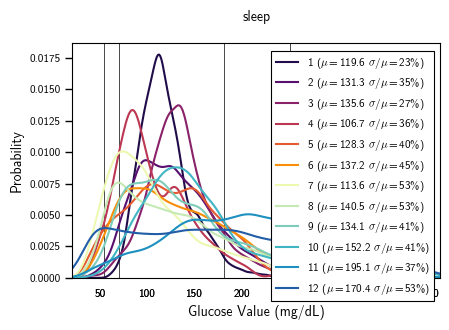

In [61]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.99))
	plt.title(sec, y=1.06)
	savefig(path='hist/hist_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

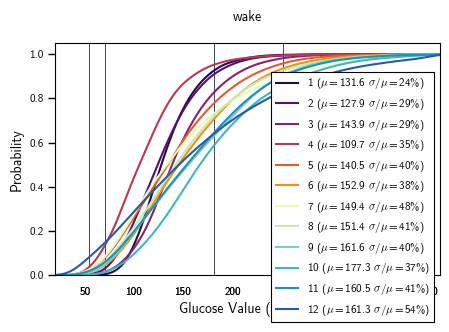

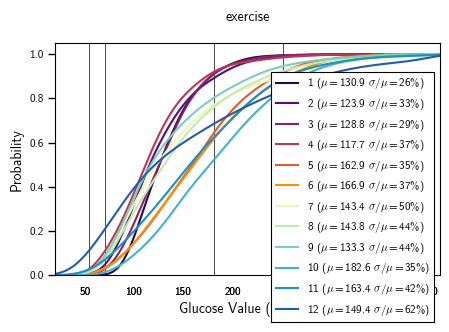

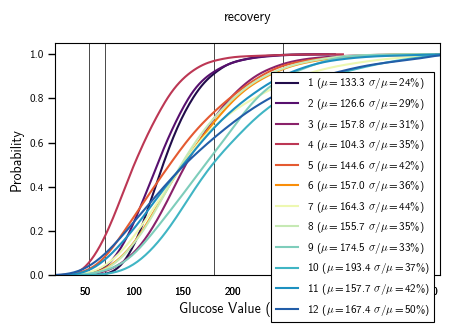

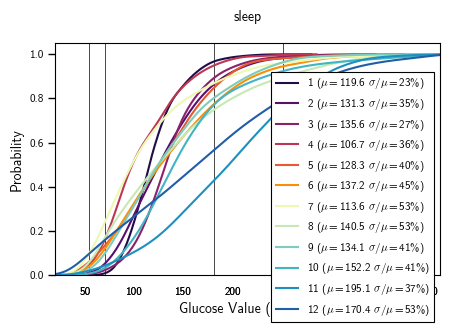

In [62]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			cumulative=True, linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
	plt.title(sec, y=1.06)
	savefig(path='cdf/cdf_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

**CONCLUSION** : Large differences among athletes

### Glucose time in level (barcharts)

In [43]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
    for c, l, h in zip([(0, 0, 0), (.5, .5, .5), (.9, .9, .9), (.5, .5, .5), (0, 0, 0)],#sns.diverging_palette(10, 10, s=0, n=5), 
                       ['>250 mg/dL', '>180-250 mg/dL', '70-180 mg/dL', '54-<70 mg/dL', '<54 mg/dL'], 
                       ('//', '//', None, '\\\\', '\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

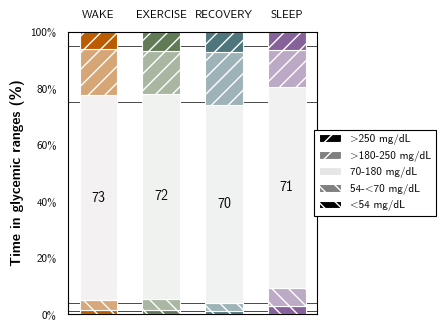

In [64]:
fig, ax = plt.subplots()

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec]])
    #pil = {l: dc_agg.groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel')

In [44]:
plt.style.use('./docs/attd.mplstyle')
SAVE_PATH = 'results/descriptives/attd/'

In [93]:
data = {'all'   : dc,
        'train' : dc[dc['exercise_day'] & ~dc['race_day']],
        'race'  : dc[dc['exercise_day'] & dc['race_day']]}
tnames = {'all'  : r"Overall "+r"({:.0f} days)".format(len(data['all'][['RIDER', 'date']].drop_duplicates())),
          'train': r"Non-competitive exercise "+r"({:.0f} days)".format(len(data['train'][['RIDER', 'date']].drop_duplicates())),
          'race' : r"Competitive exercise "+r"({:.0f} days)".format(len(data['race'][['RIDER', 'date']].drop_duplicates()))}

In [47]:
def plot_bar(data, x, width=.8, colors=dict(h_neg=10, h_pos=10, s=0, l=50), ax=plt, 
	plot_numbers=False, labelsize=10, unit='', duration=None,
	hatch = ('\\\\', '\\\\', None, '//', '//')):
	color_palette = sns.diverging_palette(**colors, n=5)
	bottom = 0
	for sec, (label, y) in enumerate(data.items()):
		c = ax.bar(x=x, height=y, width=width, bottom=bottom, color=color_palette[sec], hatch=hatch[sec], edgecolor='black')
		bottom += y
		if plot_numbers and y >= 4:
			if sec == 2:
				ax.bar_label(c, labels=['%.0f'%y+unit], label_type='center', fontsize=labelsize, color='black')
			elif plot_numbers == 'full':
				ax.bar_label(c, labels=['%.0f'%y+unit], label_type='center', fontsize=labelsize, fontweight='bold', color='white')
	if duration:
		ax.text(x, -8, duration, ha='center', color='black')

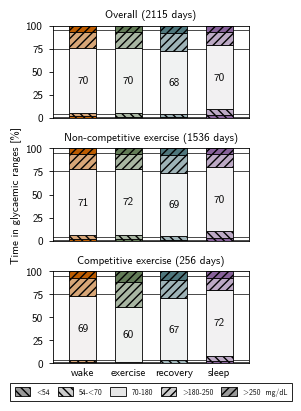

In [94]:
fig, axs = plt.subplots(3,1, figsize=(2.9,4), sharex=True, sharey=True, layout='constrained')

hatch = ('////', '////', None, '\\\\\\\\', '\\\\\\\\')

# grid in plot
for ax, day in zip(axs, data):
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        #pil = get_percinlevel(data[day][data[day][sec]])
        pil = data[day][data[day][sec]].groupby('RIDER').apply(get_percinlevel).apply(pd.Series).mean()
        plot_bar(pil, x=k, ax=ax, width=.6, colors=colors[k], plot_numbers='half', labelsize=8, hatch=hatch[::-1])

    ax.set_title(tnames[day])
    ax.margins(x=0.1)
    #ax.set_position([0, 0, 1, 1])
    sns.despine(ax=ax, bottom=False, right=False, top=False)
    ax.tick_params(axis='y', left=True)

axs[2].set_xticks(np.arange(len(SECTIONS)), SECTIONS)
axs[2].set_xticklabels([sec.lower() for sec in SECTIONS])
axs[2].tick_params(axis='x', which='major', labelbottom=True, bottom=False, top=False, labeltop=False, pad=0)
#axs[0].xaxis.set_label_position('top')

axs[1].set_ylabel('Time in glycaemic ranges [%]')#, weight='bold')

for ax in axs:
    ax.set_ylim((0,100))
    #ax.set_yticks(np.arange(0, 101, 25), ['{}%'.format(j) for j in np.arange(0, 101, 25)])

#ax.xaxis.set_label_coords(0.4, 1.12)
#ax.yaxis.set_label_coords(0.4, 1.12)

legend_elements = [Patch(facecolor=c, edgecolor='black', hatch=h, label=l) \
    for c, l, h in zip([(0.6, 0.6, 0.6), (.8, .8, .8), (.9, .9, .9), (.8, .8, .8), (0.6, 0.6, 0.6)],#sns.diverging_palette(10, 10, s=0, n=5), 
                       #['>250 mg/dL', '>180-250 mg/dL', '70-180 mg/dL', '54-<70 mg/dL', '<54 mg/dL'], 
                       ['>250  mg/dL', '>180-250', '70-180', '54-<70', '<54'], 
                       #['hyper L2', 'hyper L1', 'EU', 'hypo L1', 'hypo L2'],
                       hatch)] 

leg = axs[2].legend(handles=legend_elements[::-1], loc='lower center', ncol=5,
                columnspacing=1, handleheight=1.5, borderpad=0.6, bbox_to_anchor=(0.5, -0.45))
savefig('time_in_zone/time_in_glucoselevel_all')

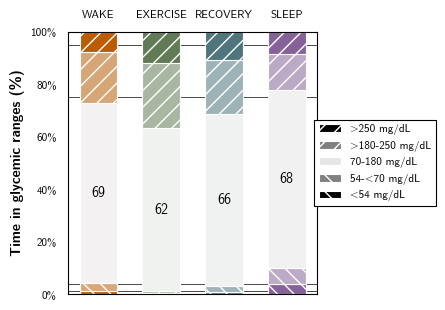

In [62]:
fig, ax = plt.subplots(figsize=(4.6, 3.2))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & dc['race_day'] & dc['exercise_day']])
    #pil = {l: dc_agg[dc_agg['race_day'] & dc_agg['exercise_day']].groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel_competition')

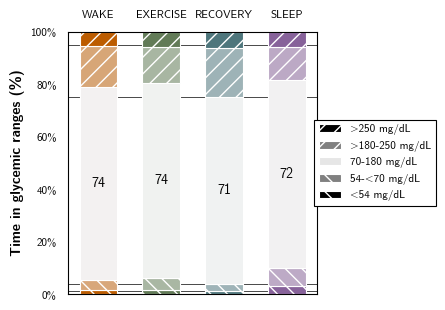

In [63]:
fig, ax = plt.subplots(figsize=(4.6, 3.2))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & ~dc['race_day'] & dc['exercise_day']])
    #pil = {l: dc_agg[~dc_agg['race_day'] & dc_agg['exercise_day']].groupby('RIDER').mean()[f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
savefig('time_in_zone/time_in_glucoselevel_training')

Individual athletes, hue: stages

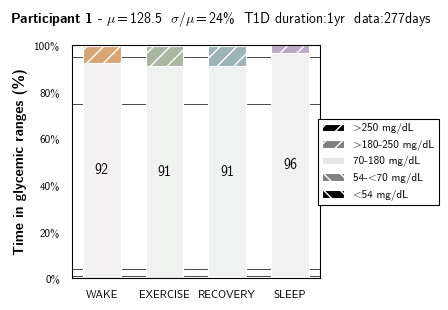

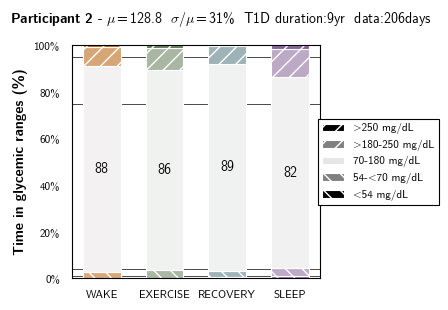

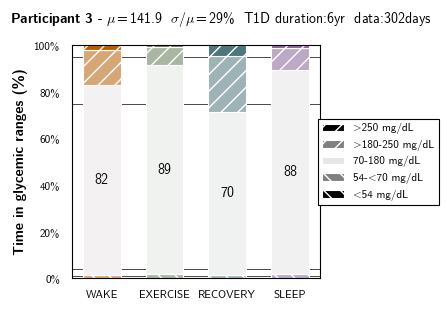

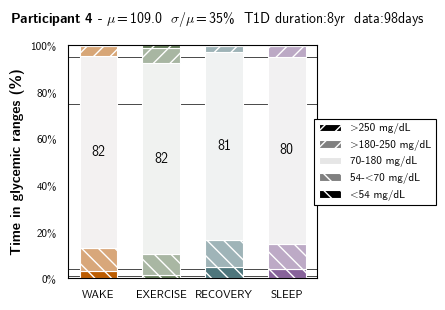

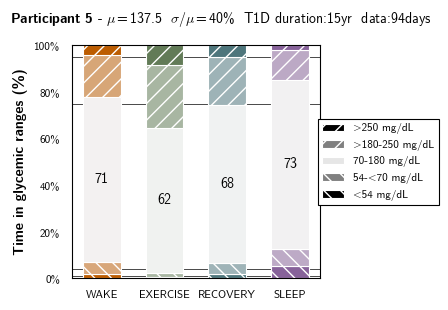

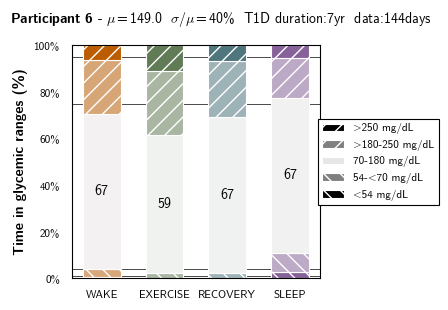

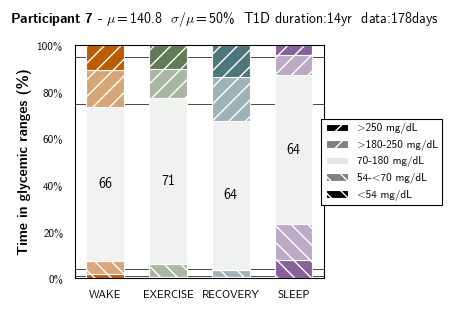

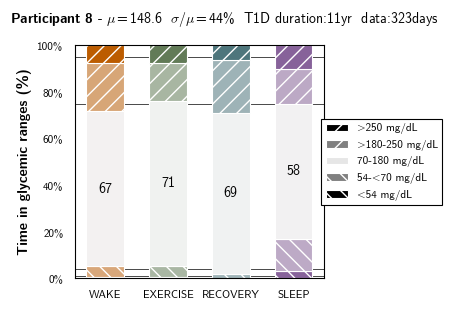

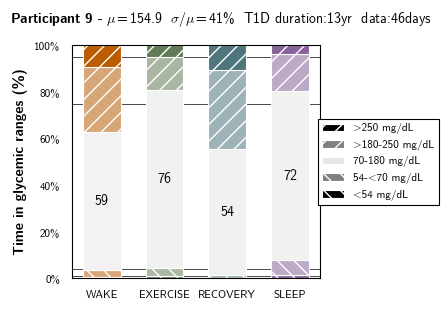

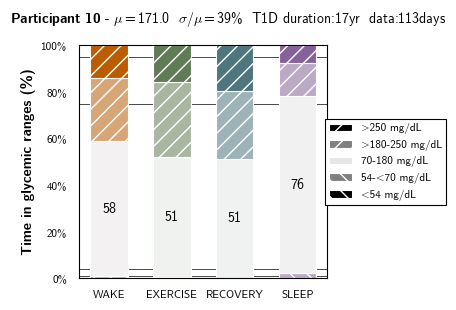

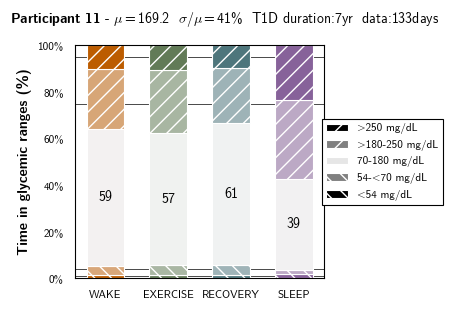

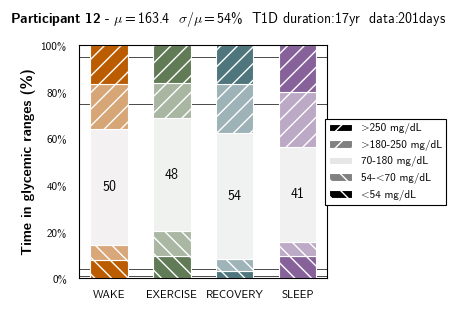

In [64]:
# TODO: check if calculation of perc_in_level is now correct!! (irvine looks weird!)
for i in ATHLETES:
    fig, ax = plt.subplots(figsize=(4.6, 3.2))

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i)])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half')

    plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
    plt.ylim((0,100))
    plt.ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.set_xticklabels([sec.upper() for sec in SECTIONS])

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
    sns.despine(ax=ax, bottom=False, right=False, top=False)
    ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    savefig(path='time_in_zone/time_in_glucoselevel', i=i, title=title, x=0.6, y=1.06)

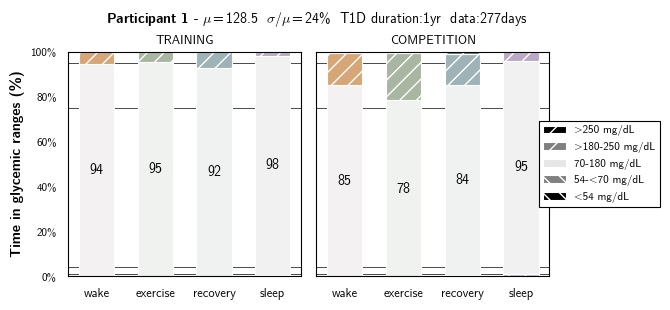

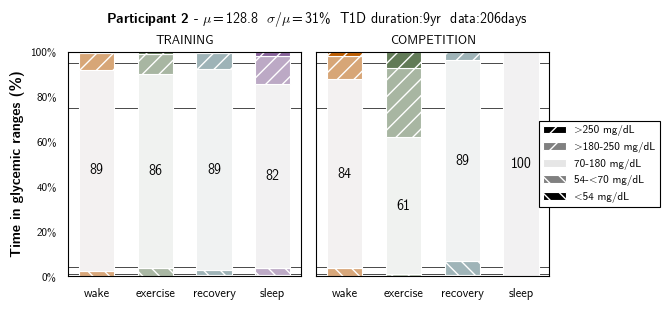

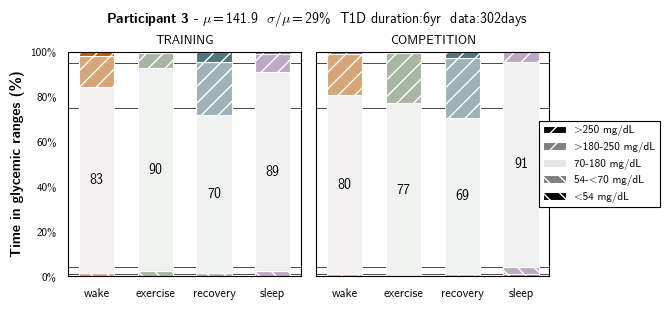

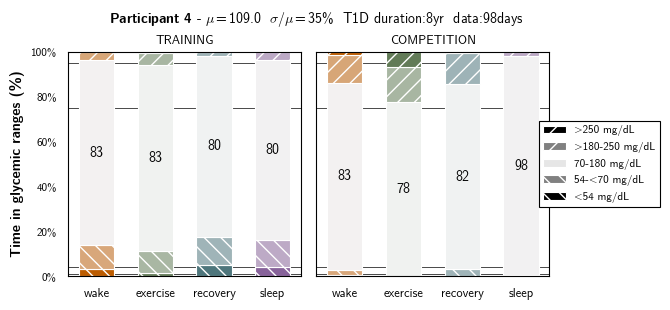

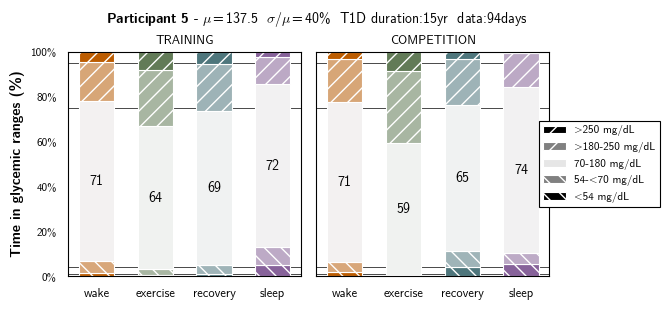

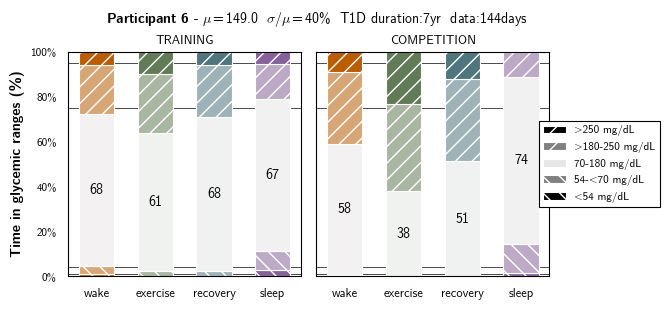

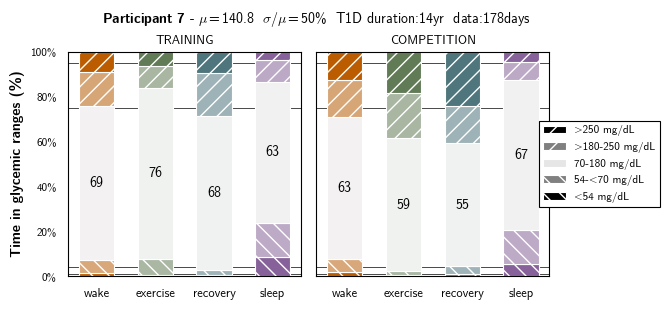

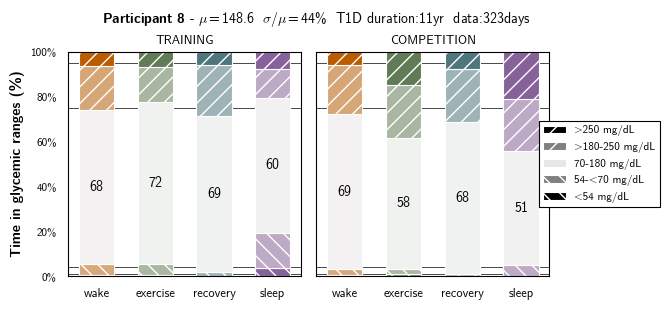

/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/eva

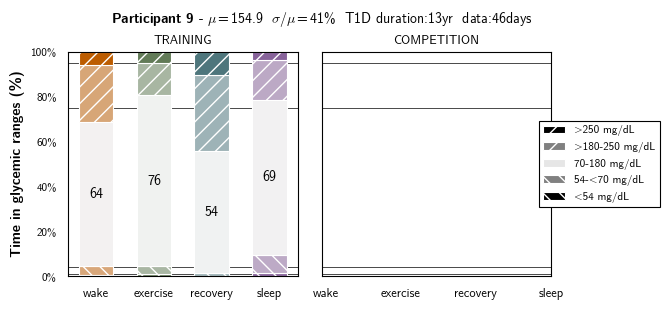

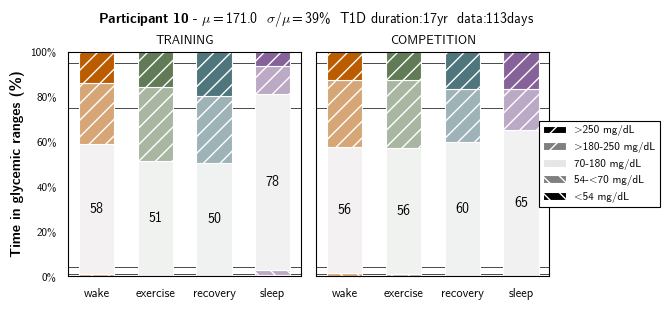

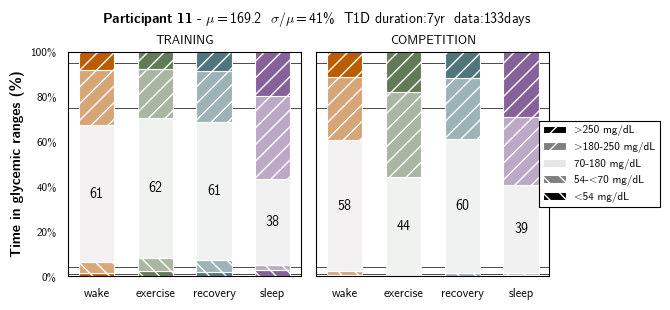

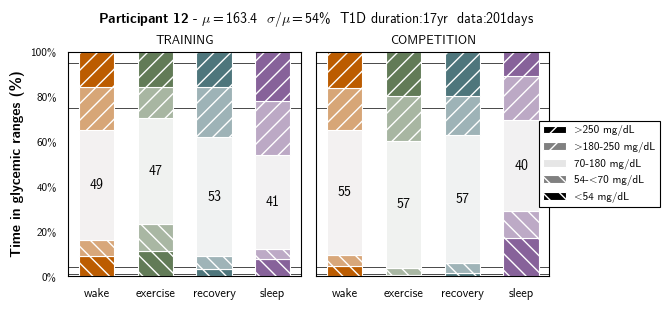

In [65]:
for i in ATHLETES:
    fig, axs = plt.subplots(1,2, figsize=(6.8, 3.2), sharey=True)
    
    for ax in axs:
        # grid in plot
        ax.axhline(1, color='k', linewidth=.5, zorder=1)
        ax.axhline(4, color='k', linewidth=.5, zorder=1)
        ax.axhline(75, color='k', linewidth=.5, zorder=1)
        ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i) & dc['exercise_day'] & ~dc['race_day']])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & dc_agg['exercise_day'] & ~dc_agg['race_day']][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half', ax=axs[0])
    
    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i) & dc['exercise_day'] & dc['race_day']])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & dc_agg['exercise_day'] & dc_agg['race_day']][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half', ax=axs[1])

    axs[0].text(0.5, 1.02, 'Training'.upper(), ha='center', va='bottom', transform=axs[0].transAxes, fontsize=9)
    axs[1].text(0.5, 1.02, 'Competition'.upper(), ha='center', va='bottom', transform=axs[1].transAxes, fontsize=9)
    
    for ax in axs:
        ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
        ax.set_xticks(np.arange(len(SECTIONS)), SECTIONS)
        ax.set_ylim((0,100))
        
        ax.set_xticklabels(SECTIONS, fontsize=9)        
        sns.despine(ax=ax, bottom=False, right=False, top=False)
        ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    axs[0].set_ylabel('Time in glycemic ranges (%)', weight='bold')
  
    axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    savefig(path='time_in_zone/time_in_glucoselevel_traincomp', i=i, title=title, x=0, y=1.09)

All, hue: athletes

In [66]:
colorful=False

In [67]:
if colorful:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in palette_ath]]
    kws = dict(ref_color = dict(h_neg=10, h_pos=10, s=0, l=50),
               ref_color_rgb = 'black',
               dur_color = 'black',
               dur_cmap = 'Greys')
else:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in len(palette_ath)*[(0, 0, 0)]]]
    kws = dict(ref_color = dict(h_pos=360, h_neg=360, l=50, s=80),
               ref_color_rgb = sns.diverging_palette(h_pos=360, h_neg=360, l=50, s=80, n=5)[0],
               dur_color = sns.diverging_palette(h_pos=90, h_neg=90, l=50, s=80, n=5)[0],
               dur_cmap = sns.light_palette((90/360, 50/360, 80/100), input='hls', as_cmap=True))

In [68]:
def plot_bar_reference(ax, n, colors=dict(h_neg=10, h_pos=10, s=0, l=50), text=True):
    ax.plot((n+1-0.2, n+1-0.2), (0, 110), color='black', clip_on=False)
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             x=n+1.5, width=.7, plot_numbers='full', ax=ax, labelsize=8, colors=colors)
    ax.annotate('3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    ax.annotate('1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    if text:
        ax.text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=sns.diverging_palette(**colors, n=5)[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

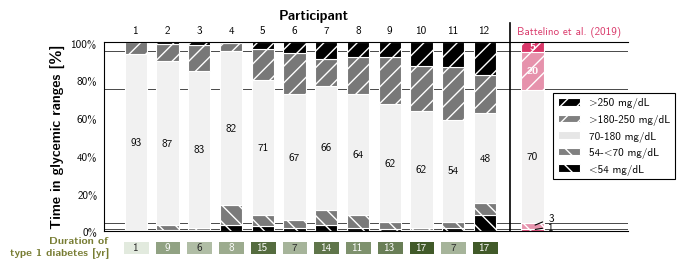

In [69]:
fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,2.5), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

# plot bars
for n, i in enumerate(ATHLETES):
    pil = get_percinlevel(dc[dc.RIDER == i])
    #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_day"].mean() for l in glucose_levels_.keys()}
    plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
             ax=ax, plot_numbers='half', labelsize=8)

# plot reference
plot_bar_reference(ax, n, colors=kws['ref_color'])
    
# ticks and axes
ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
ax.set_xlim((-1, 15.5))
ax.set_ylim((0,100))
ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
ax.set_xlabel('Participant', weight='bold')
ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

if colorful:
    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=ax, bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
ax0.set_xlim((-0.5, 16))
ax0.set_xlabel(None)
ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.87, bottom=0.01)

savefig('time_in_zone/time_in_glucoselevel_riders', xticks=ax)

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

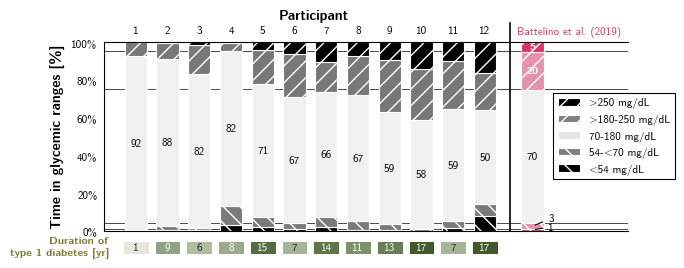

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

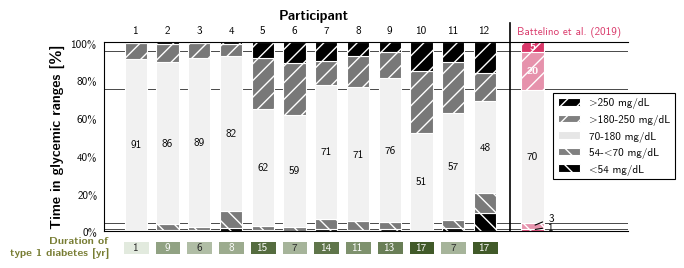

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

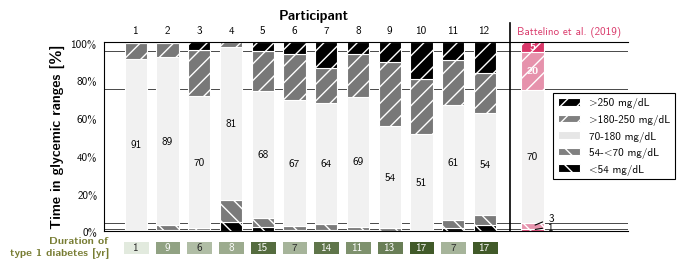

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

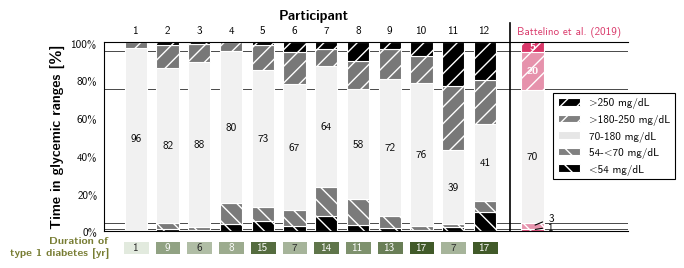

In [70]:
for sec in SECTIONS:
    fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,2.5), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
                 ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'])
    
    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
    ax.set_xlabel('Participant', weight='bold')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_label_coords(0.4, 1.12)
    ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
    sns.despine(ax=ax, bottom=False, right=True, top=False)

    # diabetes duration on bottom
    sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
                annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
    ax0.set_xlim((-0.5, 16))
    ax0.set_xlabel(None)
    ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
    ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

    #ax0.text(n/2, 2, sec.upper())
    plt.subplots_adjust(left=0.15, right=0.92, top=0.87, bottom=0.01)

    savefig('time_in_zone/time_in_glucoselevel_riders_%s'%sec, xticks=ax)

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

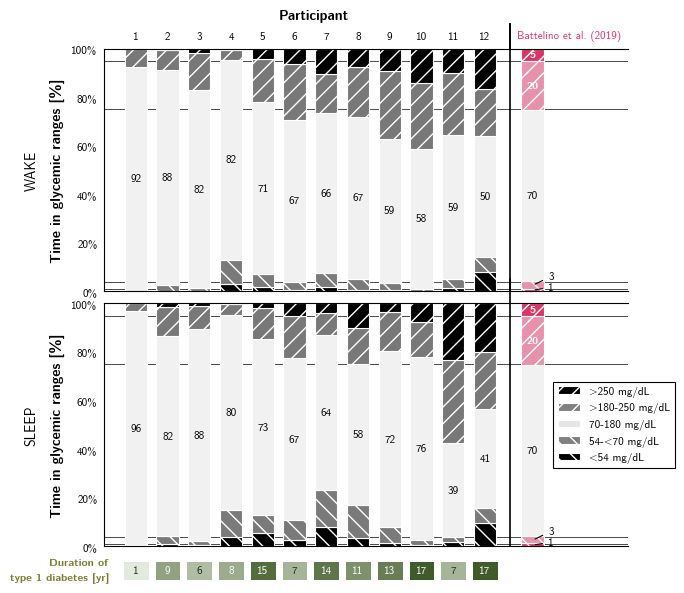

In [71]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('wake', 'sleep')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_daynight', xticks=axs[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.pdf')#, bbox_inches='tight')
/local/home/evanweenen/hype-life-diabetes-athlete/plot.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{SAVE_PATH}/{path}_{i}.png', dpi=1000)#, bbox_inches='tight')
/local/home/evanw

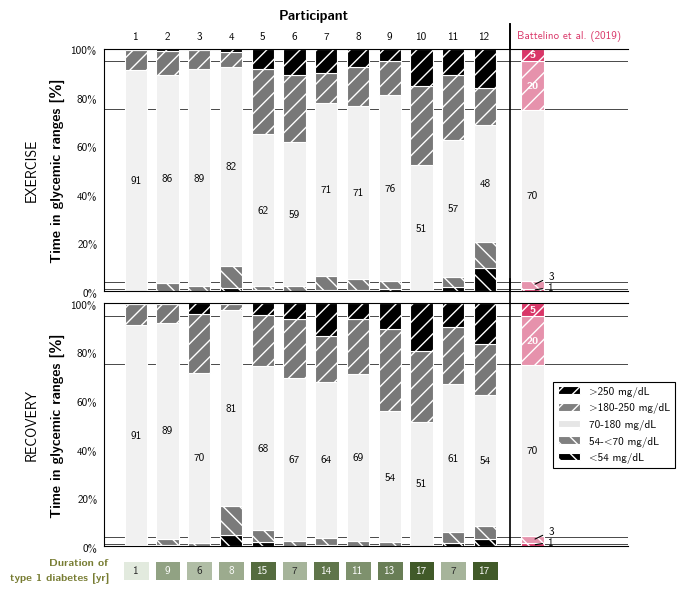

In [72]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('exercise', 'recovery')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        #pil = {l: dc_agg[dc_agg.RIDER == i][f"perc_in_{l.replace(' ', '')}_{sec}"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_exerciserecovery', xticks=axs[0])

/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/evanweenen/hype-life-diabetes-athlete/calc.py:65: RuntimeWarning: invalid value encountered in long_scalars
  return ((x >= levels[l][0]) & (x <= levels[l][1])).sum() / x.count() * 100
/local/home/eva

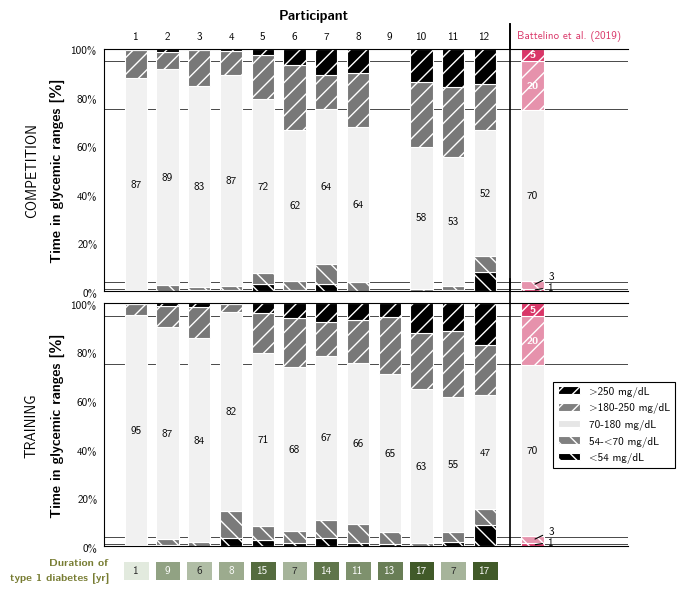

In [73]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})
MASK = {'competition': dc['race_day'] & dc['exercise_day'],
        'training'   : ~dc['race_day'] & dc['exercise_day']}
for ax, (sec, mask) in zip(axs[:2], MASK.items()):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & mask])
        #pil = {l: dc_agg[(dc_agg.RIDER == i) & mask][f"perc_in_{l.replace(' ', '')}_exercise"].mean() for l in glucose_levels_.keys()}
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], plot_numbers='half', labelsize=8)
    
    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
        
    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)
 
# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

plt.subplots_adjust(left=0.15, right=0.92, top=0.92, bottom=0.03)

savefig('time_in_zone/time_in_glucoselevel_riders_competitiontrain', xticks=axs[0])

**CONCLUSION** : Large differences among athletes

### Glucose during cycling (longitudinal)

In [42]:
color_race['train'] = (0.6, 0.6, 0.6)#tuple(list(color_race['race'])[1:] + [color_race['race'][0]])#

In [43]:
dc['cat'] = np.nan
dc.loc[dc['exercise_day'] & ~dc['race_day'], 'cat'] = 'NCE'
dc.loc[dc['exercise_day'] & dc['race_day'], 'cat'] = 'CE'

In [44]:
n = {'Overall': len(dc[['RIDER', 'date']].drop_duplicates()),
     'NCE'    : len(dc.loc[dc['cat'] == 'NCE', ['RIDER', 'date']].drop_duplicates()),
     'CE'     : len(dc.loc[dc['cat'] == 'CE', ['RIDER', 'date']].drop_duplicates())}

In [45]:
dc['t'] = (dc.local_timestamp - dc.date - pd.to_timedelta('6h')).dt.total_seconds().astype(int)

In [46]:
# exercise id
dc['id_ex'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['id_ex'] = dc['id_ex'].fillna(method='ffill')

In [47]:
dc['t_exercise'] = np.nan
dc.loc[dc['exercise'], 't_exercise'] = dc[dc['exercise']].groupby('id_ex')['t'].transform(lambda x: x - x.min()).astype(int)

dc['t_recovery'] = np.nan
dc.loc[dc['recovery'], 't_recovery'] = dc[dc['recovery']].groupby('id_ex')['t'].transform(lambda x: x - x.min()).astype(int)

dc['t_sleep'] = np.nan
dc.loc[dc['sleep'], 't_sleep'] = dc.loc[dc['sleep'], 't']
dc['t_sleep'] -= pd.to_timedelta('18h').total_seconds()

In [48]:
list(color_race['race'])+[0.4]

[0.8455062527192158, 0.21363575247920147, 0.4145075850498335, 0.4]

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


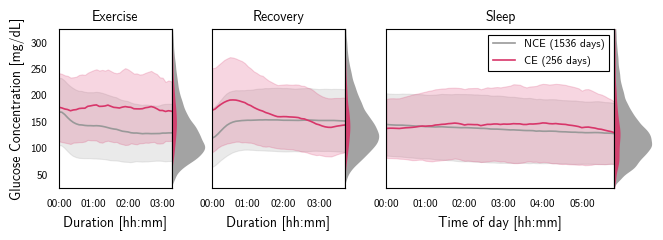

In [57]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

sections = ('exercise', 'recovery', 'sleep')
lengths = {k: dc.groupby('id_ex')[f't_{k}'].max().mean() for k in sections}

fig, ax = plt.figure(figsize=(6.8,2.5), constrained_layout=True), np.empty((3,3), dtype=object)
gs = GridSpec(1,3, figure=fig, width_ratios=list(lengths.values()), wspace=0)

for i, sec, xlabel in zip(np.arange(3), sections, ('Duration [hh:mm]', 'Duration [hh:mm]', 'Time of day [hh:mm]')):

    gs_i = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[i], wspace=0, width_ratios=[lengths[sec],3600,600])
    ax[i,0] = fig.add_subplot(gs_i[0])
    ax[i,1] = fig.add_subplot(gs_i[1], sharey=ax[i,0])

    # time series plot
    #sns.lineplot(data=dc, x=f't_{sec}', y=COL, ci='sd', ax=ax[i,0], color=(0.6, 0.6, 0.6), label='Overall')
    sns.lineplot(data=dc, x=f't_{sec}', y=COL, ci='sd', ax=ax[i,0], hue='cat', 
                 palette=list(color_race.values()), err_kws = dict(alpha=.2))
    #sns.lineplot(data=dc[dc['cat']=='NCE'], x=f't_{sec}', y=COL, ci='sd', ax=ax[i,0], color=color_race['race'], label='NCE',
    #            err_kws = dict(facecolor=list(color_race['race'])+[0.1], 
    #                           edgecolor=list(color_race['race'])+[0.9]))
    #sns.lineplot(data=dc[dc['cat']=='CE'], x=f't_{sec}', y=COL, ci='sd', ax=ax[i,0], color=color_race['train'], label='CE',
    #             err_kws = dict(facecolor=list(color_race['train'])+[0.1], 
    #                            edgecolor=list(color_race['train'])+[0.9]))

    
    ax[i,0].set_title(sec.capitalize())
    ax[i,0].set_xlabel(xlabel)
    
    if i == 2:
        ax[i,0].legend(handles=ax[i,0].get_legend().get_lines(), 
                       labels=['{:s} ({:.0f} days)'.format(text.get_text(), n[text.get_text()]) for text in ax[i,0].get_legend().get_texts()])
    else:
        ax[i,0].get_legend().remove()
    
    if i != 0:
        ax[i,0].yaxis.set_visible(False)
    else:
        ax[i,0].set_ylabel('Glucose Concentration [mg/dL]')
    ax[i,0].set_xlim((0, lengths[sec]))
    ax[i,1].set_ylim((25, 325))
    ax[i,0].set_xticks(ticks=np.arange(0, lengths[sec], 3600),
                       labels=pd.date_range(start='2022-01-01 00:00:00', periods=lengths[sec]/3600+1, freq='1h').strftime('%H:%M'))

    # distribution plot
    #sns.kdeplot(data=dc[dc[sec]], y=COL, ax=ax[i,1], color=(0.6, 0.6, 0.6), label='Overall',
    #            fill=True, alpha=.9, linewidth=0, legend=False)
    sns.kdeplot(data=dc[dc[sec]], y=COL, ax=ax[i,1], hue='cat', hue_order=['CE', 'NCE'], palette=list(color_race.values())[::-1],
                fill=True, alpha=.9, linewidth=0, legend=False)

    sns.despine(bottom=True, right=True, top=True, ax=ax[i,1])
    ax[i,1].yaxis.set_visible(False)
    ax[i,1].xaxis.set_visible(False)
    
    #ax[i,0].axhline(54, ls='--', color='black', lw=.5)
    #ax[i,0].axhline(70, ls=':', color='black', lw=.5)
    #ax[i,0].axhline(180, ls=':', color='black', lw=.5)
    #ax[i,0].axhline(250, ls='--', color='black', lw=.5)

#ax[2,0].text(0.9, 0.1, 'L2 hypoglycemia', fontsize=8, transform=ax[2,0].transAxes)
#ax[2,0].text(4.2*3600, 54, 'L2 hypoglycemia', fontsize=6)
#ax[2,0].text(4.2*3600, 70, 'L1 hypoglycemia', fontsize=6)
#ax[2,0].text(4.1*3600, 180, 'L1 hyperglycemia', fontsize=6)
#ax[2,0].text(4.1*3600, 250, 'L2 hyperglycemia', fontsize=6)

plt.savefig(f'{SAVE_PATH}/timeseries/timeseries_.pdf')
plt.savefig(f'{SAVE_PATH}/timeseries/timeseries_.png')
plt.show()

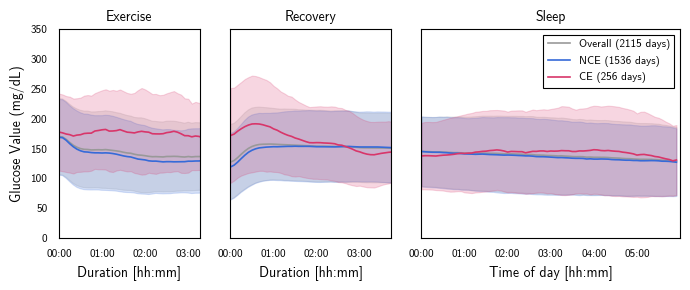

In [348]:
fig, ax = plt.subplots(1,3, figsize=(7,3), sharey=True, tight_layout=True,
                       gridspec_kw={'width_ratios': list(lengths.values())})

# exercise
sns.lineplot(data=dc, x='t_exercise', y=COL, ci='sd', ax=ax[0], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t_exercise', y=COL, ci='sd', ax=ax[0], hue='cat', palette=list(color_race.values()))

ax[0].set_title('Exercise')
ax[0].set_xlabel('Duration [hh:mm]')
ax[0].legend(handles=ax[0].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[0].get_legend().get_texts()])
ax[0].set_xlim((0, lengths['exercise']))
ax[0].set_xticks(ticks=np.arange(0, lengths['exercise']+1, 1*3600),
                 labels=pd.date_range(start='2022-01-01 00:00:00', periods=lengths['exercise']/3600+1, freq='1h').strftime('%H:%M'))
ax[0].get_legend().remove()

# recovery
sns.lineplot(data=dc, x='t_recovery', y=COL, ci='sd', ax=ax[1], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t_recovery', y=COL, ci='sd', ax=ax[1], hue='cat', palette=list(color_race.values()))

ax[1].set_title('Recovery')
ax[1].set_xlabel('Duration [hh:mm]')
ax[1].legend(handles=ax[1].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[1].get_legend().get_texts()])
ax[1].set_xlim((0, lengths['recovery']))
ax[1].set_xticks(ticks=np.arange(0, lengths['recovery']+1, 1*3600),
                 labels=pd.date_range(start='2022-01-01 00:00:00', periods=lengths['recovery']/3600+1, freq='1h').strftime('%H:%M'))
ax[1].get_legend().remove()

# sleep
sns.lineplot(data=dc, x='t_sleep', y=COL, ci='sd', ax=ax[2], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t_sleep', y=COL, ci='sd', ax=ax[2], hue='cat', palette=list(color_race.values()))

ax[2].set_title('Sleep')
ax[2].set_xlabel('Time of day [hh:mm]')
ax[2].legend(handles=ax[2].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[2].get_legend().get_texts()])
ax[2].set_xlim((0, 6*3600))
ax[2].set_xticks(ticks=np.arange(0, lengths['sleep']+1, 1*3600),
                 labels=pd.date_range(start='2022-01-02 00:00:00', periods=lengths['sleep']/3600+1, freq='1h').strftime('%H:%M'))
plt.ylim((0,350))
plt.show()

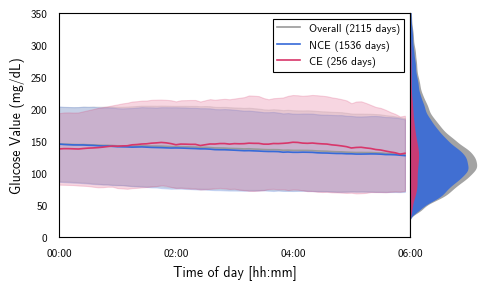

In [289]:
fig, ax = plt.subplots(1,2, figsize=(5,3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)

# time series plot
sns.lineplot(data=dc, x='t_sleep', y=COL, ci='sd', ax=ax[0], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t_sleep', y=COL, ci='sd', ax=ax[0], hue='cat', palette=list(color_race.values()))

ax[0].set_xlabel('Time of day [hh:mm]')
ax[0].legend(handles=ax[0].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[0].get_legend().get_texts()])
ax[0].set_xlim((0, 6*3600))
plt.ylim((0,350))
ax[0].set_xticks(ticks=np.arange(0, 6*3600+1, 2*3600),
                 labels=pd.date_range(start='2022-01-02 00:00:00', end='2022-01-02 06:00:00', freq='2h').strftime('%H:%M'))

# distribution plot
sns.kdeplot(data=dc[dc['sleep']], y=COL, ax=ax[1], color=(0.6, 0.6, 0.6), label='Overall',
            fill=True, alpha=.9, linewidth=0, legend=False)
sns.kdeplot(data=dc[dc['sleep']], y=COL, ax=ax[1], hue='cat', hue_order=['CE', 'NCE'], palette=list(color_race.values())[::-1],
            fill=True, alpha=.9, linewidth=0, legend=False)

sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])

plt.show()

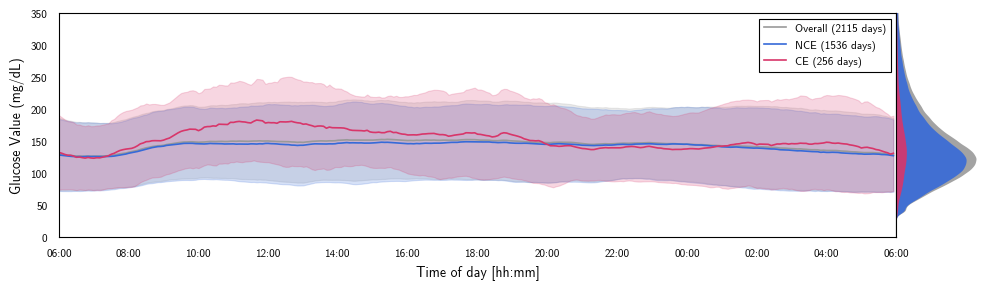

In [223]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharey=True, gridspec_kw={'width_ratios': [10, 1], 'wspace':0}, tight_layout=True)

# time series plot
sns.lineplot(data=dc, x='t', y=COL, ci='sd', ax=ax[0], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t', y=COL, ci='sd', ax=ax[0], hue='cat', palette=list(color_race.values()))

ax[0].set_xlabel('Time of day [hh:mm]')
ax[0].legend(handles=ax[0].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[0].get_legend().get_texts()])
ax[0].set_xlim((0, 24*3600))
plt.ylim((0,350))
ax[0].set_xticks(ticks=np.arange(0, 24*3600+1, 2*3600),
                 labels=pd.date_range(start='2022-01-01 06:00:00', end='2022-01-02 06:00:00', freq='2h').strftime('%H:%M'))

# distribution plot
sns.kdeplot(data=dc, y=COL, ax=ax[1], color=(0.6, 0.6, 0.6), label='Overall',
            fill=True, alpha=.9, linewidth=0, legend=False)
sns.kdeplot(data=dc, y=COL, ax=ax[1], hue='cat', hue_order=['CE', 'NCE'], palette=list(color_race.values())[::-1],
            fill=True, alpha=.9, linewidth=0, legend=False)

sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])

plt.show()

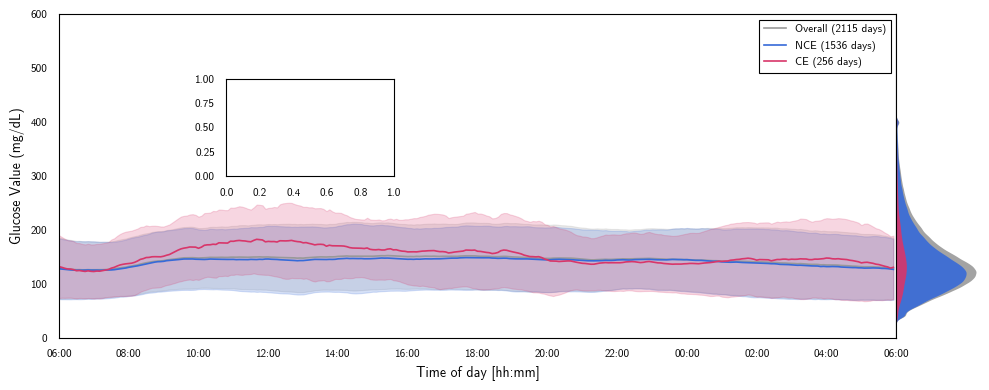

In [286]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, gridspec_kw={'width_ratios': [10, 1], 'wspace':0}, tight_layout=True)

# time series plot
sns.lineplot(data=dc, x='t', y=COL, ci='sd', ax=ax[0], color=(0.6, 0.6, 0.6), label='Overall')
sns.lineplot(data=dc, x='t', y=COL, ci='sd', ax=ax[0], hue='cat', palette=list(color_race.values()))

ax[0].set_xlabel('Time of day [hh:mm]')
ax[0].legend(handles=ax[0].get_legend().get_lines(), 
             labels=['{:s} ({:.0f} days)'.format(text.get_text(), 
                                                 n[text.get_text()]) \
                     for text in ax[0].get_legend().get_texts()])
ax[0].set_xlim((0, 24*3600))
plt.ylim((0,600))
ax[0].set_xticks(ticks=np.arange(0, 24*3600+1, 2*3600),
                 labels=pd.date_range(start='2022-01-01 06:00:00', end='2022-01-02 06:00:00', freq='2h').strftime('%H:%M'))

# distribution plot
sns.kdeplot(data=dc, y=COL, ax=ax[1], color=(0.6, 0.6, 0.6), label='Overall',
            fill=True, alpha=.9, linewidth=0, legend=False)
sns.kdeplot(data=dc, y=COL, ax=ax[1], hue='cat', hue_order=['CE', 'NCE'], palette=list(color_race.values())[::-1],
            fill=True, alpha=.9, linewidth=0, legend=False)

sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])

ax_ex = ax[0].inset_axes((0.2, 0.5, .2, .3))
plt.show()

## Unused analyses

### Competition vs. training

### Glucose distribution (boxplots)

In [74]:
kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=color_race['race'], hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['race']), capprops=dict(color=color_race['race'])),
		   'train':dict(boxprops=dict(color='w', facecolor=color_race['train'], hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['train']), capprops=dict(color=color_race['train']))}

All, stratify: sections

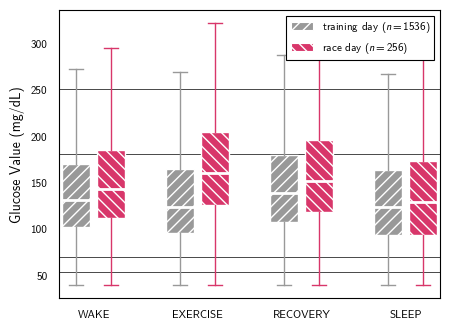

In [75]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

fig, ax = plt.subplots()

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)
    
for k, sec in enumerate(SECTIONS):
	plt.boxplot(dc.loc[dc[sec] & ~dc['race_day'] & dc['exercise_day'], COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[dc[sec] & dc['race_day'] & dc['exercise_day'], COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
ax.set_xticklabels([sec.upper() for sec in SECTIONS])
savefig('boxplot/box_glucose_sections')

Individual athletes, stratify: sections

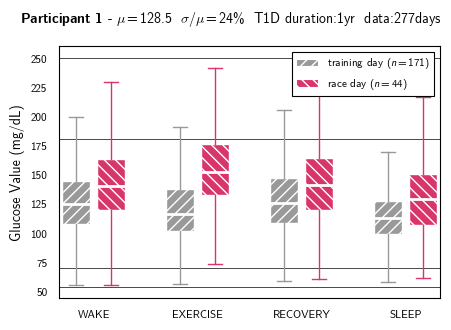

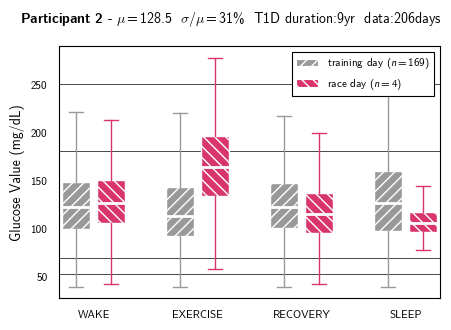

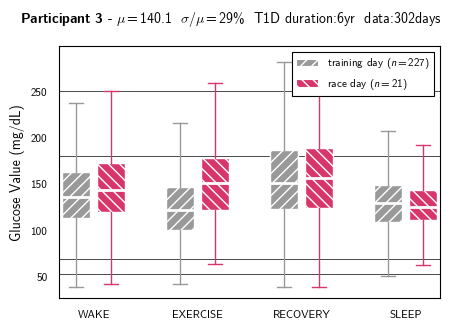

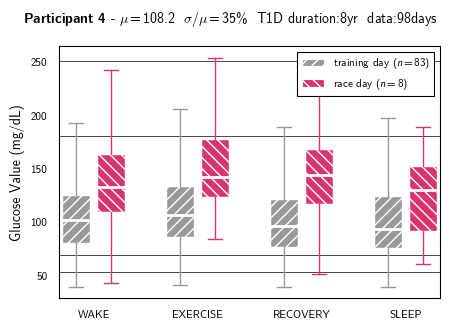

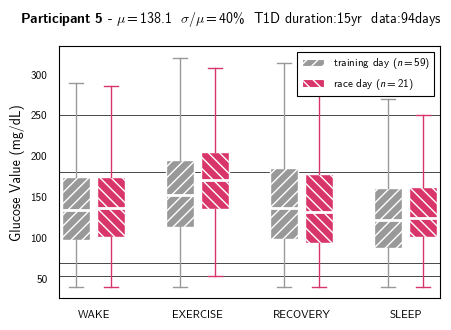

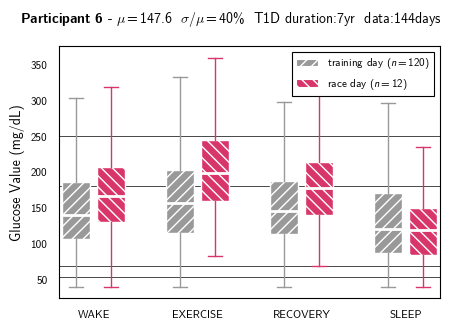

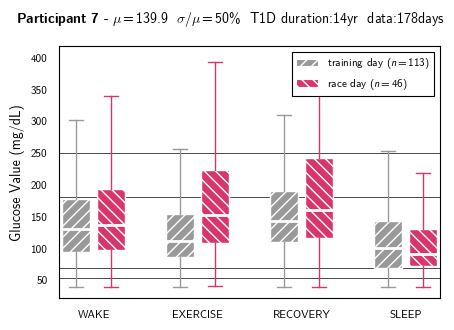

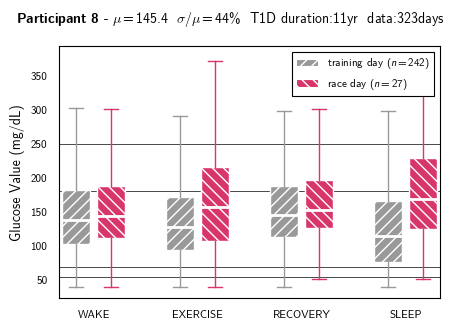

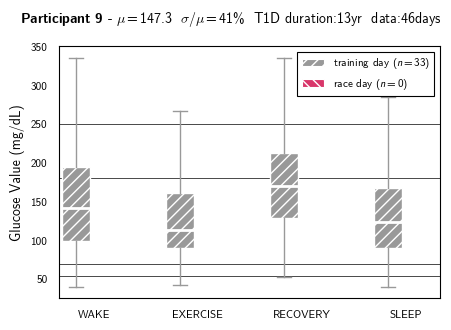

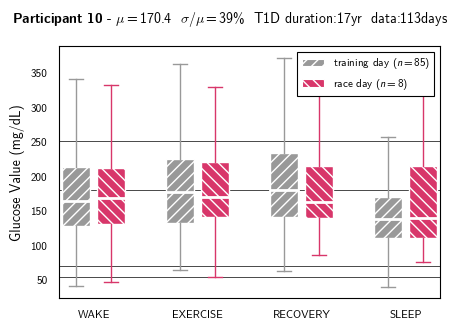

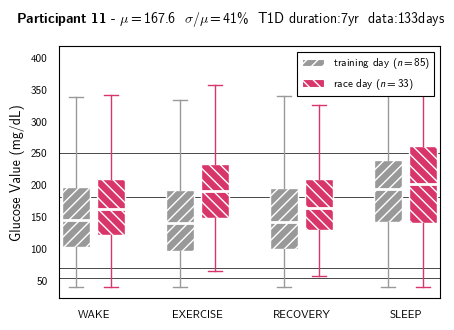

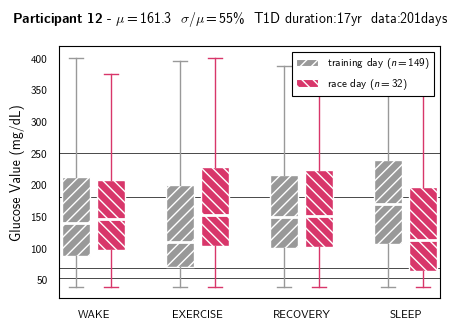

In [76]:
for i in ATHLETES:
    n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], 'date'].unique())
    n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], 'date'].unique())

    fig, ax = plt.subplots()

    # grid in plot
    for _, l in list(glucose_levels.items())[1:]:
        ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & ~dc['race_day'] & dc['exercise_day'], COL], positions=[k+0.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['train'])
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race_day'] & dc['exercise_day'], COL], positions=[k+1.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['race'])
    plt.xticks([1,4,7,10], SECTIONS)
    plt.ylabel(COL)
    plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
                        Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
                loc='upper right')

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
                dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    ax.set_xticklabels([sec.upper() for sec in SECTIONS])
    savefig(path='boxplot/box_glucose_sections', i=i, title=title, x=0.45, y=1.06)

All, stratify: athletes

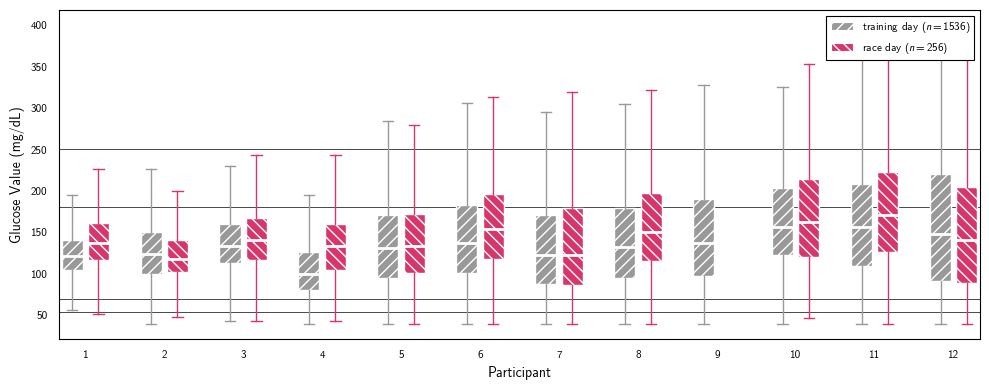

In [77]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

for n, i in enumerate(ATHLETES):
	plt.boxplot(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL) ; plt.xlabel('Participant')
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks(np.arange(1, len(ATHLETES)*3,3), ATHLETES)

savefig('boxplot/box_glucose_riders', xticks=ax)

### Glucose during cycling (longitudinal)

In [78]:
# session id
dc['tid'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['tid'] = dc['tid'].fillna(method='ffill')

# time within session
dc['t'] = dc.groupby('tid').cumcount() * 5
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            8 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            8 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            8 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            8 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            8 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1267159      9 2019-01-27 04:35:00                   70.0 2019-01-27 05:35:00   
1267160      9 2019-01-27 04:40:00                   72.0 2019-01-27 05:40:00   
1267161      9 2019-01-27 04:45:00                   73.0 2019-01-27 05:45:00   
1267162      9 2019-01-27 04:50:00                   54.0 2019-01-27 05:50:00   
1267163      9 2019-01-27 04:55:00                   69.0 2019-01-27 05:55:00   

         exercise  recovery   wake  sleep       date  race_day  travel_day  \
0           False     False   True  False 2018-11-05     False       False   
1           False     False   True  False 2018-11-05     False       False   
2           False     False   True  False 2018-11-05     False       False   
3           False     False   True  False 2018-11-05     False       False   
4           False     False   True  False 2018-11-05     False       False   
...           ...       ...    ...    ...        ...       ...         ...   
1267159     False     False  False   True 2019-01-26     False       False   
1267160     False     False  False   True 2019-01-26     False       False   
1267161     False     False  False   True 2019-01-26     False       False   
1267162     False     False  False   True 2019-01-26     False       False   
1267163     False     False  False   True 2019-01-26     False       False   

         exercise_day   hypo  hyper  glucose_rate  completeness     tid     t  
0                True  False  False          -5.0      0.920139     0.0     0  
1                True  False  False           0.0      0.920139     0.0     5  
2                True  False  False           0.0      0.920139     0.0    10  
3                True  False  False           0.0      0.920139     0.0    15  
4                True  False  False           0.0      0.920139     0.0    20  
...               ...    ...    ...           ...           ...     ...   ...  
1267159          True  False  False           0.0      0.961806  1971.0  1135  
1267160          True  False  False           2.0      0.961806  1971.0  1140  
1267161          True  False  False           1.0      0.961806  1971.0  1145  
1267162          True  False  False         -19.0      0.961806  1971.0  1150  
1267163          True  False  False          15.0      0.961806  1971.0  1155  

[574962 rows x 18 columns]

All

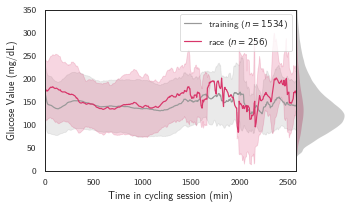

In [90]:
n_nc = len(dc.loc[~dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day'] & dc['exercise_day'], ['RIDER', 'date']].drop_duplicates())

t_max = dc.groupby('tid')['t'].max().quantile(0.9) #dc['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(data = dc[dc['exercise_day']], x='t', y=COL, hue='race_day', ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(), 
	labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'+r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=dc.loc[dc['t'].notna() & dc['exercise_day']], y=COL, hue='race_day', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
savefig('time_cycling/glucose_cycling')

Individual athletes

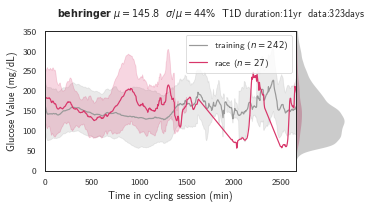

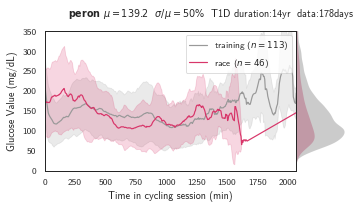

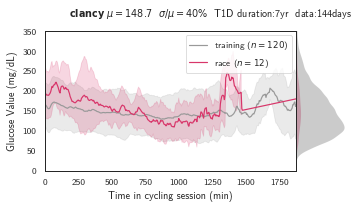

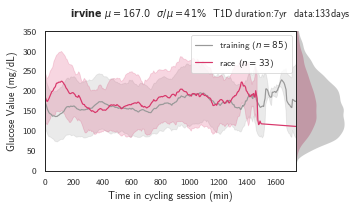

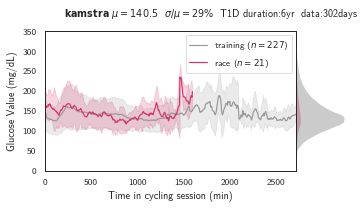

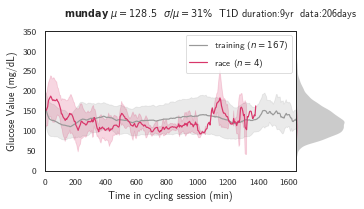

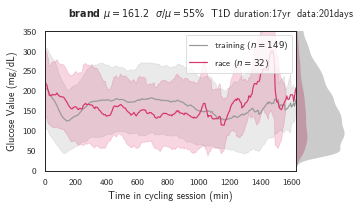

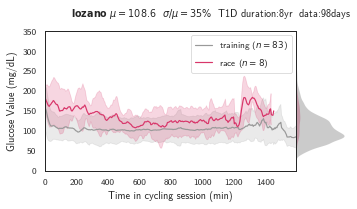

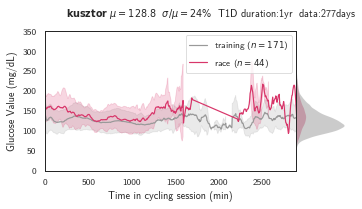

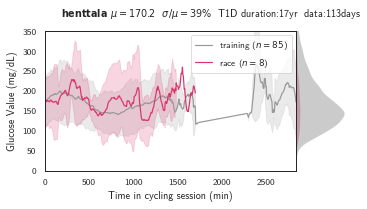

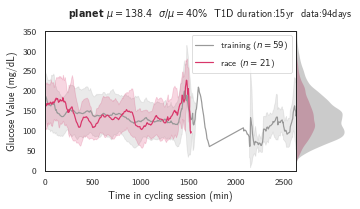

In [93]:
for i in dc[dc['race_day']].RIDER.unique():
	n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day'] & dc['exercise_day'], 'date'].unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day'] & dc['exercise_day'], 'date'].unique())

	t_max = dc[dc.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#dc.loc[dc.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(data=dc[(dc.RIDER == i) & dc['exercise_day']], x='t', y=COL, ci='sd', hue='race_day', palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(),
		labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=dc.loc[dc['t'].notna() & (dc.RIDER == i) & dc['exercise_day']], y=COL, hue='race_day', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
				dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='time_cycling/glucose_cycling', i=i, title=title, x=-1.7, y=1.06)

### Glucose during day

In [89]:
dc['time'] = timestamp_to_seconds(dc['local_timestamp'])

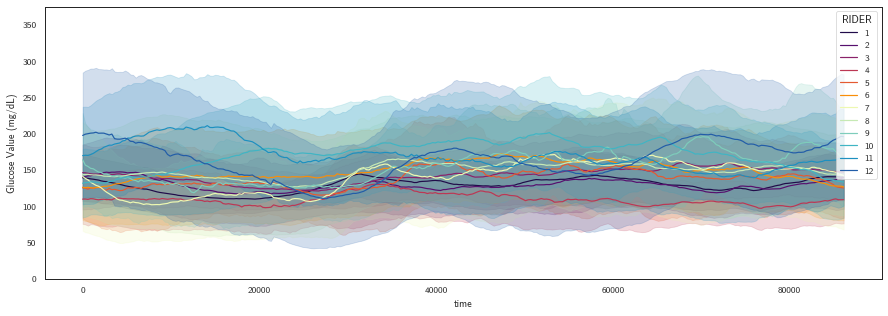

In [90]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dc, x='time', y=COL, ci='sd', hue='RIDER', palette=palette_ath)
plt.ylim((0,375))
plt.show()

### Days with hypo events (during sections)

In [104]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

In [ ]:
dc_hypo = {}
for sec in SECTIONS+('1d',):
    dc_hypo[sec] = dc_agg['hypo_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hypo = pd.concat(dc_hypo, axis=1) * 100
dc_hypo = dc_hypo.rename(columns={'1d':'total'})

In [82]:
dc_hyper = {}
for sec in SECTIONS+('1d',):
    dc_hyper[sec] = dc_agg['hyper_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hyper = pd.concat(dc_hyper, axis=1) * 100
dc_hyper = dc_hyper.rename(columns={'1d':'total'})

Text(0.5, 1.0, 'Days in hyperglycemia')

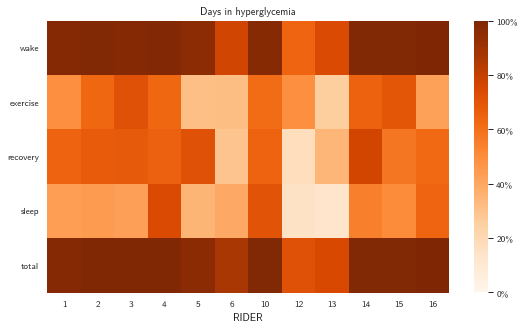

In [83]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hyper.T, vmin=0, vmax=100, cmap='Oranges')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])
plt.yticks(rotation=0)
plt.title("Days in hyperglycemia")

Text(0.5, 1.0, 'Days in hypoglycemia')

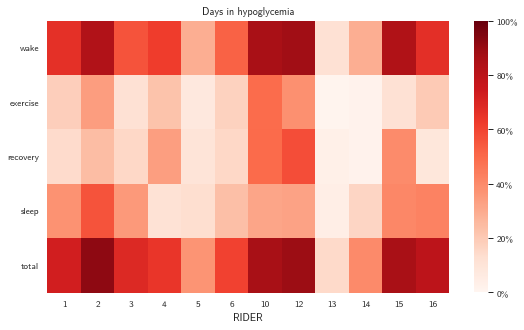

In [84]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hypo.T, vmin=0, vmax=100, cmap='Reds')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])

plt.yticks(rotation=0)
plt.title("Days in hypoglycemia")

In [85]:
dc_events = {}
for sec in SECTIONS+('1d',):
    dc_events[sec] = dc_agg[['time_in_hypo_'+sec, 'time_in_hyper_'+sec]].div(dc_agg['count_'+sec], axis=0)
    dc_events[sec].columns = ['_'.join(col.split('_')[:-1]) for col in dc_events[sec].columns]
    dc_events[sec] *= 100
    dc_events[sec] = dc_events[sec].sort_index(level=1)
    mask = (dc_events[sec]['time_in_hypo'] != 0) & (dc_events[sec]['time_in_hyper'] != 0)
    dc_events[sec].loc[mask, 'time_in_both'] = dc_events[sec]['time_in_hypo'] + dc_events[sec]['time_in_hyper']
    dc_events[sec].loc[mask, ['time_in_hypo', 'time_in_hyper']] = 0
    dc_events[sec] = dc_events[sec].replace({0:np.nan})

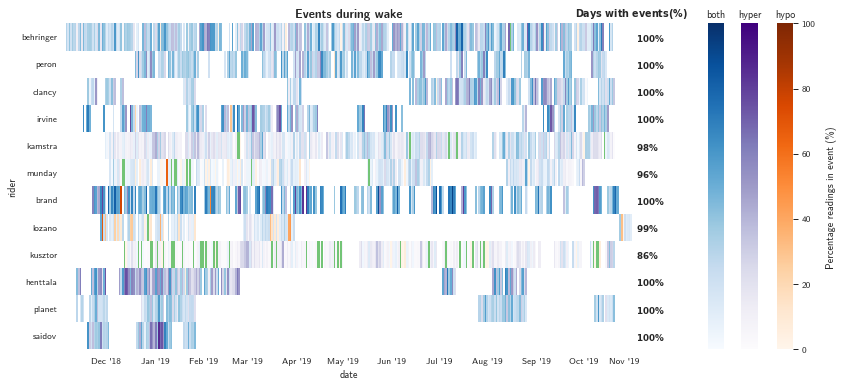

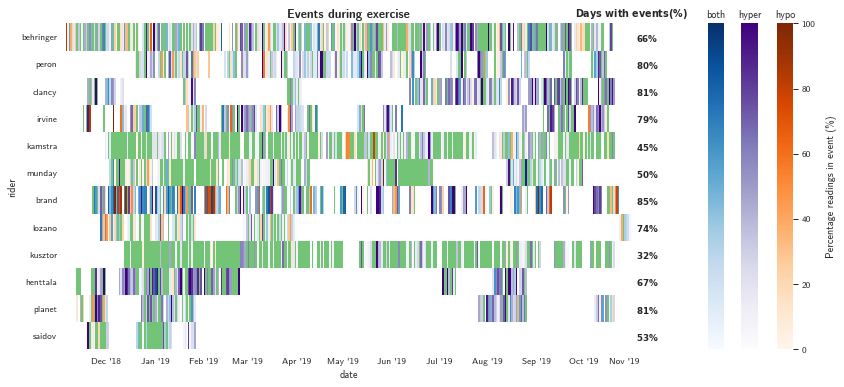

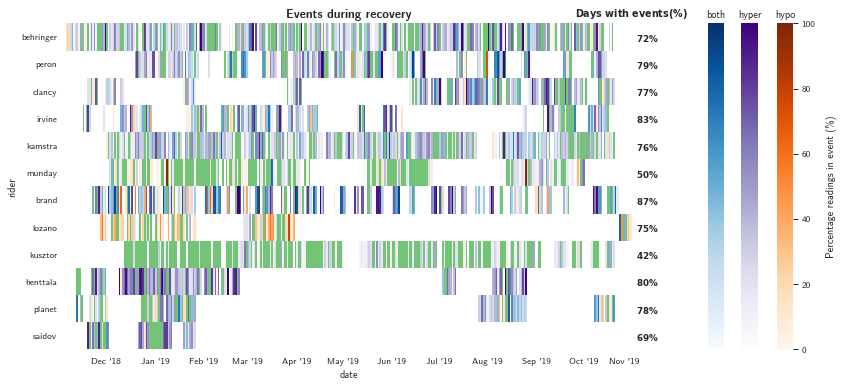

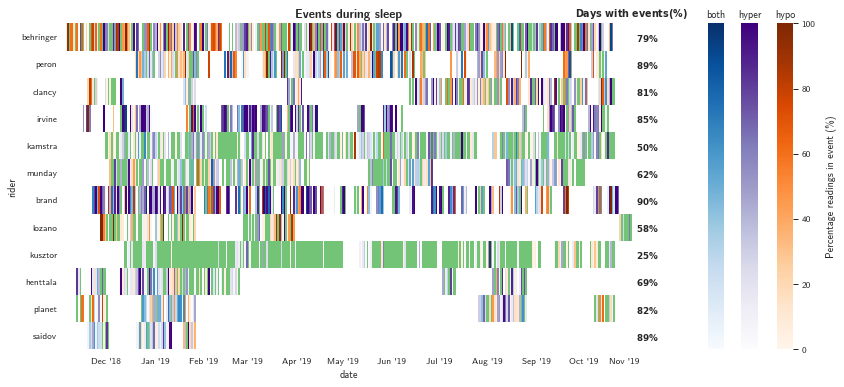

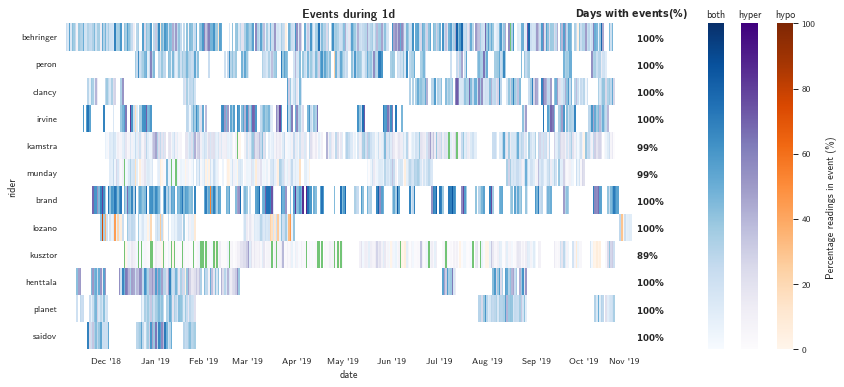

In [86]:
EVENTS = {'hypo': {'cmap':'Oranges', 'cbar_kws':{'pad':-0.1}},
          'hyper':{'cmap':'Purples', 'cbar_kws':{'pad':-0.1}}, 
          'both': {'cmap':'Blues'  , 'cbar_kws':{'pad':0.1}}}
for sec in SECTIONS+('1d',):
    fig, ax = plt.subplots(figsize=(15,6))
    
    df_avail = dc_events[sec].isna().all(axis=1).astype(float).unstack()
    sns.heatmap(df_avail, ax=ax, vmin=0, vmax=2, cmap='Greens', cbar=False)
    for event, kwargs in EVENTS.items():
        df_avail = dc_events[sec]['time_in_'+event].unstack()
        sns.heatmap(df_avail, ax=ax, vmin=0, vmax=100, **kwargs)
    
    # percentage columns
    perc_events = dc_events[sec].unstack().count(axis=1)/\
        dc_events[sec].reset_index().groupby('RIDER')['date'].count()*100
    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
    ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in perc_events])
    ax2.tick_params(axis='y', length=0)
    ax2.spines['right'].set_visible(False)
    ax.text(0.9, 1.02, r'$\bf{:s}$'.format('Days\ with\ events (\%)'), ha='left', transform=ax.transAxes) 
    
    # colorbar
    for j, cbar_ax in enumerate(fig.get_axes()[1:]):
        if j != 0:
            cbar_ax.set_yticks([]) ; cbar_ax.set_yticklabels([])
        cbar_ax.set_title(list(EVENTS.keys())[j])
        if j == 0:
            cbar_ax.text(3, dc_events[sec].max().max()/2, 'Percentage readings in event (%)', va='center', rotation=90)
            
    monthyear = df_avail.columns.strftime("%b '%y")
    ticksloc = np.where(monthyear.to_series().shift() != monthyear.to_series())[0][1:]
    plt.xticks(ticks=ticksloc, labels=monthyear[ticksloc], rotation=0)
    plt.xlabel('date')
    plt.ylabel('rider')
    plt.title('Events during '+sec, fontweight='bold', fontsize=12)
    savefig('events/events', i=sec, yticks=ax)